In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
deathtrooper_multichannel_glaucoma_benchmark_dataset_path = kagglehub.dataset_download('deathtrooper/multichannel-glaucoma-benchmark-dataset')

print('Data source import complete.')


100%|██████████| 2.93G/2.93G [01:15<00:00, 41.4MB/s]

Extracting files...


Data source import complete.


In [ ]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [ ]:
import tensorflow as tf

# Number of classes (background, OC, OD)
num_classes = 3

# Input layer
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Rescaling(1./255)(inputs)

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# Output layer for multi-class segmentation
outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

# Model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,139 (7.40 MB)

 Trainable params: 1,941,139 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Base SMDG path: /root/.cache/kagglehub/datasets/deathtrooper/multichannel-glaucoma-benchmark-dataset/versions/10
Top-level contents: ['optic-disc', 'spectral-oct-cup', 'vessel-artery', 'full-fundus', 'optic-cup', 'spectral-oct-disc', 'metadata - standardized.csv', 'vessel-vein', 'blood-vessel', 'spectral-oct']
Fundus dir: /root/.cache/kagglehub/datasets/deathtrooper/multichannel-glaucoma-benchmark-dataset/versions/10/full-fundus/full-fundus -> True
OC dir    : /root/.cache/kagglehub/datasets/deathtrooper/multichannel-glaucoma-benchmark-dataset/versions/10/optic-cup/optic-cup -> True
OD dir    : /root/.cache/kagglehub/datasets/deathtrooper/multichannel-glaucoma-benchmark-dataset/versions/10/optic-disc/optic-disc -> True
Total fundus images found: 12449
Loaded 2873 samples, skipped 9576 fundus images with missing masks.
X_original shape: (2873, 256, 256, 3)
X_clahe shape   : (2873, 256, 256, 3)
Y shape         : (2873, 256, 256, 3)
X_train_original shape: (2442, 256, 256, 3)
X_train_clah

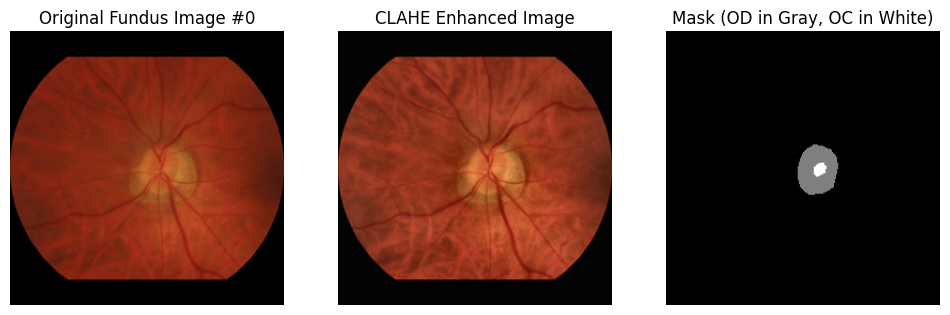

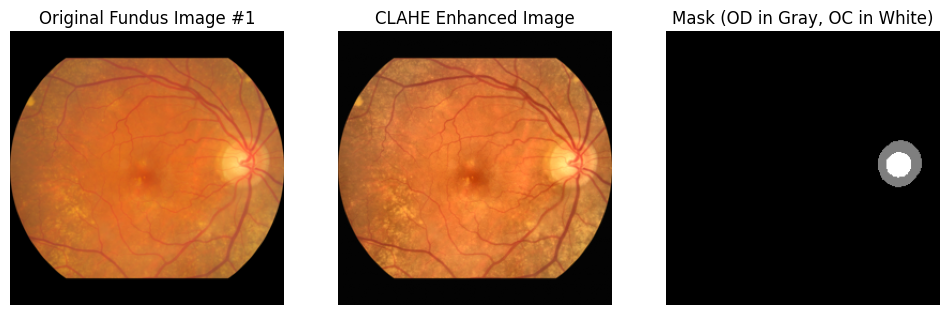

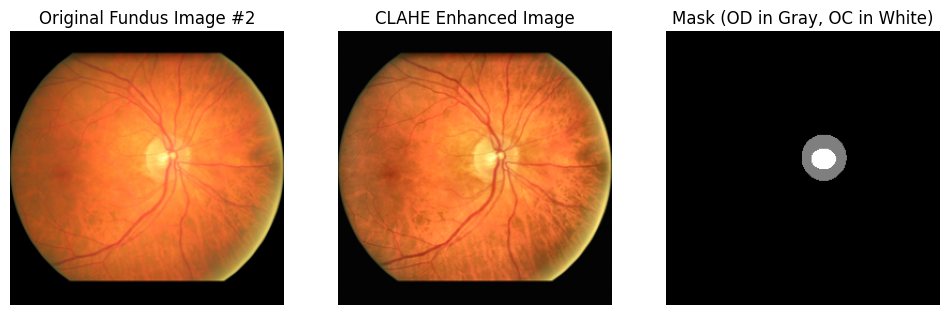

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

# Base directory from kagglehub download
base_dir = deathtrooper_multichannel_glaucoma_benchmark_dataset_path
print("Base SMDG path:", base_dir)
print("Top-level contents:", os.listdir(base_dir))

# ✅ Correct nested directories
fundus_dir = os.path.join(base_dir, "full-fundus/full-fundus")
oc_dir     = os.path.join(base_dir, "optic-cup/optic-cup")
od_dir     = os.path.join(base_dir, "optic-disc/optic-disc")

print("Fundus dir:", fundus_dir, "->", os.path.exists(fundus_dir))
print("OC dir    :", oc_dir, "->", os.path.exists(oc_dir))
print("OD dir    :", od_dir, "->", os.path.exists(od_dir))

# Image parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 3  # Background, Optic Disc (OD), Optic Cup (OC)

# Function to apply CLAHE to an image
def apply_clahe(image):
    # Convert RGB to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Split LAB channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L (lightness) channel
    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    # Merge CLAHE-enhanced L-channel back with A and B channels
    lab_clahe = cv2.merge((l_clahe, a, b))

    # Convert LAB back to RGB
    clahe_img = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    return clahe_img

# Function to load and preprocess fundus images and masks
def load_and_preprocess_data(fundus_dir, oc_dir, od_dir, img_height, img_width, num_classes):
    images_original = []
    images_clahe = []
    masks = []
    skipped = 0

    fundus_filenames = sorted(os.listdir(fundus_dir))
    print("Total fundus images found:", len(fundus_filenames))

    for filename in fundus_filenames:
        fundus_path = os.path.join(fundus_dir, filename)

        # Get base name without extension
        base_name = os.path.splitext(filename)[0]

        # Find corresponding OC and OD mask (could be PNG or JPG)
        oc_path = next(
            (os.path.join(oc_dir, f"{base_name}.{ext}") for ext in ["png", "jpg"]
             if os.path.exists(os.path.join(oc_dir, f"{base_name}.{ext}"))),
            None
        )
        od_path = next(
            (os.path.join(od_dir, f"{base_name}.{ext}") for ext in ["png", "jpg"]
             if os.path.exists(os.path.join(od_dir, f"{base_name}.{ext}"))),
            None
        )

        # Skip if any mask is missing
        if not oc_path or not od_path:
            skipped += 1
            continue

        # Load fundus image
        fundus_img = Image.open(fundus_path).convert("RGB")
        fundus_img = fundus_img.resize((img_width, img_height))
        fundus_img = np.array(fundus_img)

        # Apply CLAHE
        fundus_clahe = apply_clahe(fundus_img)

        images_original.append(fundus_img)
        images_clahe.append(fundus_clahe)

        # Load OC and OD masks
        oc_mask = Image.open(oc_path).convert("L").resize((img_width, img_height))
        od_mask = Image.open(od_path).convert("L").resize((img_width, img_height))

        oc_mask = np.array(oc_mask)
        od_mask = np.array(od_mask)

        # Normalize mask values to 0 and 255 / 128
        oc_mask = np.where(oc_mask > 0, 255, 0).astype(np.uint8)  # OC = 255
        od_mask = np.where(od_mask > 0, 128, 0).astype(np.uint8)  # OD = 128

        # Combine masks (OC has priority over OD)
        combined_mask = np.maximum(oc_mask, od_mask)

        # Convert to one-hot encoding
        one_hot_mask = np.zeros((img_height, img_width, num_classes), dtype=np.float32)
        one_hot_mask[combined_mask == 0,   0] = 1  # Background
        one_hot_mask[combined_mask == 128, 1] = 1  # OD
        one_hot_mask[combined_mask == 255, 2] = 1  # OC

        masks.append(one_hot_mask)

    print(f"Loaded {len(images_original)} samples, skipped {skipped} fundus images with missing masks.")
    return np.array(images_original), np.array(images_clahe), np.array(masks)

# Load dataset
X_original, X_clahe, Y = load_and_preprocess_data(fundus_dir, oc_dir, od_dir, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)

# Sanity check
print("X_original shape:", X_original.shape)
print("X_clahe shape   :", X_clahe.shape)
print("Y shape         :", Y.shape)

# Normalize images
X_original = X_original / 255.0
X_clahe    = X_clahe / 255.0

# Shuffle dataset
indices = np.arange(len(X_clahe))
np.random.shuffle(indices)
X_original = X_original[indices]
X_clahe    = X_clahe[indices]
Y          = Y[indices]

# Split dataset
X_train_original, X_test_original, X_train_clahe, X_test_clahe, Y_train, Y_test = train_test_split(
    X_original, X_clahe, Y, test_size=0.15, random_state=42
)

# Print shapes
print(f"X_train_original shape: {X_train_original.shape}")
print(f"X_train_clahe shape   : {X_train_clahe.shape}")
print(f"Y_train shape          : {Y_train.shape}")
print(f"X_test_original shape  : {X_test_original.shape}")
print(f"X_test_clahe shape     : {X_test_clahe.shape}")
print(f"Y_test shape           : {Y_test.shape}")

# Function to display original, CLAHE image, and mask
def display_sample(original, clahe, mask, index):
    plt.figure(figsize=(12, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title(f"Original Fundus Image #{index}")
    plt.axis("off")

    # CLAHE Image
    plt.subplot(1, 3, 2)
    plt.imshow(clahe)
    plt.title("CLAHE Enhanced Image")
    plt.axis("off")

    # Combined Mask
    plt.subplot(1, 3, 3)
    mask_combined = np.argmax(mask, axis=-1)  # Decode one-hot mask

    # Custom colormap: Black (0), Gray (1), White (2)
    color_map = {0: (0, 0, 0), 1: (0.5, 0.5, 0.5), 2: (1, 1, 1)}
    mask_rgb = np.zeros((mask_combined.shape[0], mask_combined.shape[1], 3), dtype=np.float32)

    for label, color in color_map.items():
        mask_rgb[mask_combined == label] = color

    plt.imshow(mask_rgb)
    plt.title("Mask (OD in Gray, OC in White)")
    plt.axis("off")

    plt.show()

# Display a few samples
for i in range(3):
    display_sample(X_train_original[i], X_train_clahe[i], Y_train[i], i)


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

# ---------------------------------------------
# 📌 1. LOCAL DATASET PATH (YOUR GOOGLE DRIVE)
# ---------------------------------------------
base_dir = "/content/drive/MyDrive/Glaucoma detection"

print("Base directory:", base_dir)
print("Top-level contents:", os.listdir(base_dir))

# Folder paths
fundus_dir = os.path.join(base_dir, "full-fundus/full-fundus")
oc_dir     = os.path.join(base_dir, "optic-cup/optic-cup")
od_dir     = os.path.join(base_dir, "optic-disc/optic-disc")

print("\nResolved Paths:")
print("Fundus dir:", fundus_dir, "->", os.path.exists(fundus_dir))
print("OC dir    :", oc_dir, "->", os.path.exists(oc_dir))
print("OD dir    :", od_dir, "->", os.path.exists(od_dir))

# ---------------------------------------------
# 📌 2. PARAMETERS
# ---------------------------------------------
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 3   # Background, OD, OC

# ---------------------------------------------
# 📌 3. CLAHE FUNCTION
# ---------------------------------------------
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

# ---------------------------------------------
# 📌 4. LOAD IMAGES + MASKS
# ---------------------------------------------
def load_and_preprocess_data(fundus_dir, oc_dir, od_dir, img_height, img_width, num_classes):
    images_original = []
    images_clahe = []
    masks = []
    skipped = 0

    fundus_filenames = sorted(os.listdir(fundus_dir))
    print("\nTotal fundus images found:", len(fundus_filenames))

    for filename in fundus_filenames:
        fundus_path = os.path.join(fundus_dir, filename)
        base_name = os.path.splitext(filename)[0]

        # Mask paths
        oc_path = next((os.path.join(oc_dir, f"{base_name}.{ext}")
                        for ext in ["png", "jpg"]
                        if os.path.exists(os.path.join(oc_dir, f"{base_name}.{ext}"))), None)

        od_path = next((os.path.join(od_dir, f"{base_name}.{ext}")
                        for ext in ["png", "jpg"]
                        if os.path.exists(os.path.join(od_dir, f"{base_name}.{ext}"))), None)

        if not oc_path or not od_path:
            skipped += 1
            continue

        # Load fundus
        fundus_img = Image.open(fundus_path).convert("RGB")
        fundus_img = fundus_img.resize((img_width, img_height))
        fundus_img = np.array(fundus_img)

        # CLAHE
        fundus_clahe = apply_clahe(fundus_img)

        images_original.append(fundus_img)
        images_clahe.append(fundus_clahe)

        # Load masks
        oc_mask = np.array(Image.open(oc_path).convert("L").resize((img_width, img_height)))
        od_mask = np.array(Image.open(od_path).convert("L").resize((img_width, img_height)))

        oc_mask = np.where(oc_mask > 0, 255, 0).astype(np.uint8)     # OC = white
        od_mask = np.where(od_mask > 0, 128, 0).astype(np.uint8)     # OD = gray

        combined_mask = np.maximum(oc_mask, od_mask)

        # One-hot encoding
        one_hot = np.zeros((img_height, img_width, num_classes), dtype=np.float32)
        one_hot[combined_mask == 0, 0]   = 1   # Background
        one_hot[combined_mask == 128, 1] = 1   # OD
        one_hot[combined_mask == 255, 2] = 1   # OC

        masks.append(one_hot)

    print(f"Loaded: {len(images_original)}, Skipped: {skipped}")
    return np.array(images_original), np.array(images_clahe), np.array(masks)

# Load dataset
X_original, X_clahe, Y = load_and_preprocess_data(fundus_dir, oc_dir, od_dir,
                                                  IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)

# ---------------------------------------------
# 📌 5. SHUFFLE + SPLIT
# ---------------------------------------------
X_original = X_original / 255.0
X_clahe    = X_clahe / 255.0

idx = np.arange(len(X_original))
np.random.shuffle(idx)

X_original = X_original[idx]
X_clahe    = X_clahe[idx]
Y          = Y[idx]

X_train_original, X_test_original, X_train_clahe, X_test_clahe, Y_train, Y_test = train_test_split(
    X_original, X_clahe, Y, test_size=0.15, random_state=42
)

print("\nShapes:")
print("X_train_original:", X_train_original.shape)
print("X_train_clahe   :", X_train_clahe.shape)
print("Y_train         :", Y_train.shape)
print("X_test_original :", X_test_original.shape)
print("X_test_clahe    :", X_test_clahe.shape)
print("Y_test          :", Y_test.shape)

# ---------------------------------------------
# 📌 6. SAMPLE VISUALIZATION
# ---------------------------------------------
def display_sample(original, clahe, mask, index):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title(f"Original #{index}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(clahe)
    plt.title("CLAHE")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    decoded = np.argmax(mask, axis=-1)

    cmap = {0:(0,0,0), 1:(0.5,0.5,0.5), 2:(1,1,1)}
    mask_rgb = np.zeros((*decoded.shape, 3))

    for lbl, col in cmap.items():
        mask_rgb[decoded == lbl] = col

    plt.imshow(mask_rgb)
    plt.title("Mask (OD gray, OC white)")
    plt.axis("off")

    plt.show()

# Show a few samples
for i in range(3):
    display_sample(X_train_original[i], X_train_clahe[i], Y_train[i], i)


Base directory: /content/drive/MyDrive/Glaucoma detection
Top-level contents: ['metadata - standardized.csv', 'blood-vessel', 'full-fundus', 'optic-cup', 'optic-disc', 'spectral-oct-cup', 'spectral-oct', 'vessel-vein', 'spectral-oct-disc', 'vessel-artery', 'convnext_tiny_fullfundus_best.pth', 'glauconet_tiny_fullfundus_best.pth', 'vit_b16_fullfundus_best.pth', 'checkpoints', 'oof_predictions.csv', 'Conv_checkpoints', 'oof_predictions_Convnext.csv', 'figures', 'ViT_checkpoints', 'checkpoints_vit_b16', 'oof_predictions_vit_b16.csv', 'oof_threshold_sweep.csv']

Resolved Paths:
Fundus dir: /content/drive/MyDrive/Glaucoma detection/full-fundus/full-fundus -> True
OC dir    : /content/drive/MyDrive/Glaucoma detection/optic-cup/optic-cup -> True
OD dir    : /content/drive/MyDrive/Glaucoma detection/optic-disc/optic-disc -> True

Total fundus images found: 12449


KeyboardInterrupt: 

Base directory: /content/drive/MyDrive/Glaucoma detection
Top-level contents: ['metadata - standardized.csv', 'blood-vessel', 'full-fundus', 'optic-cup', 'optic-disc', 'spectral-oct-cup', 'spectral-oct', 'vessel-vein', 'spectral-oct-disc', 'vessel-artery', 'convnext_tiny_fullfundus_best.pth', 'glauconet_tiny_fullfundus_best.pth', 'vit_b16_fullfundus_best.pth', 'checkpoints', 'oof_predictions.csv', 'Conv_checkpoints', 'oof_predictions_Convnext.csv', 'figures', 'ViT_checkpoints', 'checkpoints_vit_b16', 'oof_predictions_vit_b16.csv', 'oof_threshold_sweep.csv']

Resolved Paths:
Fundus dir        : /content/drive/MyDrive/Glaucoma detection/full-fundus/full-fundus -> True
OC dir            : /content/drive/MyDrive/Glaucoma detection/optic-cup/optic-cup -> True
OD dir            : /content/drive/MyDrive/Glaucoma detection/optic-disc/optic-disc -> True
CLAHE fundus dir  : /content/drive/MyDrive/Glaucoma detection/clahe_full_fundus -> True

CLAHE folder empty – generating CLAHE images now...


100%|██████████| 12449/12449 [08:12<00:00, 25.27it/s]


CLAHE generation done.
Example CLAHE files: ['BEH-1.png', 'BEH-10.png', 'BEH-100.png', 'BEH-101.png', 'BEH-102.png']

Total fundus images found: 12449
Loaded: 2873, Skipped: 9576

Shapes:
X_train_original: (2442, 256, 256, 3)
X_train_clahe   : (2442, 256, 256, 3)
Y_train         : (2442, 256, 256, 3)
X_test_original : (431, 256, 256, 3)
X_test_clahe    : (431, 256, 256, 3)
Y_test          : (431, 256, 256, 3)


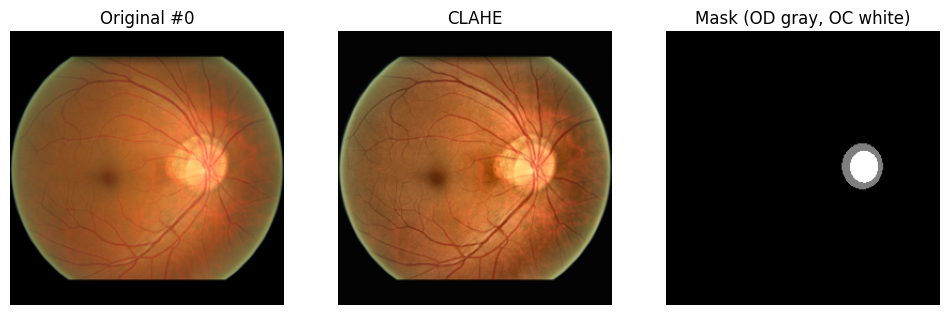

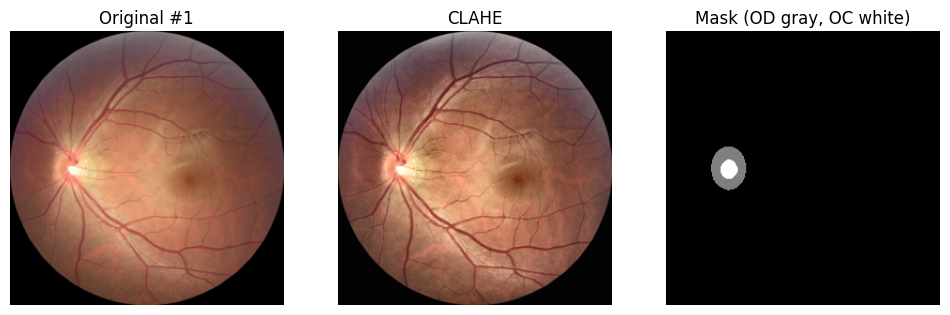

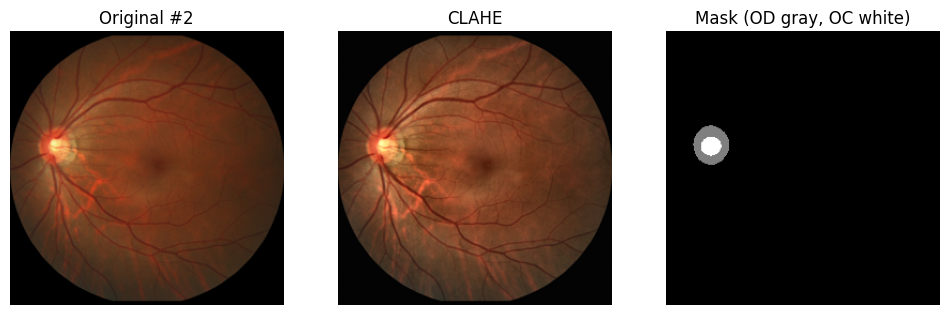

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ---------------------------------------------
# 📌 1. LOCAL DATASET PATH (YOUR GOOGLE DRIVE)
# ---------------------------------------------
base_dir = "/content/drive/MyDrive/Glaucoma detection"

print("Base directory:", base_dir)
print("Top-level contents:", os.listdir(base_dir))

# Original fundus + masks
fundus_dir = os.path.join(base_dir, "full-fundus/full-fundus")
oc_dir     = os.path.join(base_dir, "optic-cup/optic-cup")
od_dir     = os.path.join(base_dir, "optic-disc/optic-disc")

# CLAHE fundus directory (we'll create if needed)
clahe_fundus_dir = os.path.join(base_dir, "clahe_full_fundus")
os.makedirs(clahe_fundus_dir, exist_ok=True)

print("\nResolved Paths:")
print("Fundus dir        :", fundus_dir, "->", os.path.exists(fundus_dir))
print("OC dir            :", oc_dir, "->", os.path.exists(oc_dir))
print("OD dir            :", od_dir, "->", os.path.exists(od_dir))
print("CLAHE fundus dir  :", clahe_fundus_dir, "->", os.path.exists(clahe_fundus_dir))

# ---------------------------------------------
# 📌 2. PARAMETERS
# ---------------------------------------------
IMG_HEIGHT = 256
IMG_WIDTH  = 256
NUM_CLASSES = 3   # Background, OD, OC

# ---------------------------------------------
# 📌 3. CLAHE FUNCTION
# ---------------------------------------------
def apply_clahe(image_rgb):
    lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

# ---------------------------------------------
# 📌 3.1 PRECOMPUTE & SAVE CLAHE IMAGES (ONCE)
# ---------------------------------------------
# If folder is empty, generate CLAHE images
if len(os.listdir(clahe_fundus_dir)) == 0:
    print("\nCLAHE folder empty – generating CLAHE images now...")
    fundus_files = sorted(os.listdir(fundus_dir))
    for fname in tqdm(fundus_files):
        in_path = os.path.join(fundus_dir, fname)
        if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        img_bgr = cv2.imread(in_path)
        if img_bgr is None:
            continue

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_clahe_rgb = apply_clahe(img_rgb)
        img_clahe_bgr = cv2.cvtColor(img_clahe_rgb, cv2.COLOR_RGB2BGR)

        out_path = os.path.join(clahe_fundus_dir, fname)
        cv2.imwrite(out_path, img_clahe_bgr)

    print("CLAHE generation done.")
else:
    print("\nCLAHE folder already has images, skipping CLAHE generation.")

print("Example CLAHE files:", os.listdir(clahe_fundus_dir)[:5])

# ---------------------------------------------
# 📌 4. LOAD IMAGES + MASKS
# ---------------------------------------------
def load_and_preprocess_data(fundus_dir, clahe_fundus_dir, oc_dir, od_dir,
                             img_height, img_width, num_classes):
    images_original = []
    images_clahe = []
    masks = []
    skipped = 0

    fundus_filenames = sorted(os.listdir(fundus_dir))
    print("\nTotal fundus images found:", len(fundus_filenames))

    for filename in fundus_filenames:
        fundus_path      = os.path.join(fundus_dir, filename)
        clahe_fundus_path = os.path.join(clahe_fundus_dir, filename)
        base_name        = os.path.splitext(filename)[0]

        # Mask paths
        oc_path = next((os.path.join(oc_dir, f"{base_name}.{ext}")
                        for ext in ["png", "jpg"]
                        if os.path.exists(os.path.join(oc_dir, f"{base_name}.{ext}"))), None)

        od_path = next((os.path.join(od_dir, f"{base_name}.{ext}")
                        for ext in ["png", "jpg"]
                        if os.path.exists(os.path.join(od_dir, f"{base_name}.{ext}"))), None)

        # Need original, clahe, and both masks
        if not oc_path or not od_path or not os.path.exists(fundus_path) or not os.path.exists(clahe_fundus_path):
            skipped += 1
            continue

        # Load original fundus
        fundus_img = Image.open(fundus_path).convert("RGB")
        fundus_img = fundus_img.resize((img_width, img_height))
        fundus_img = np.array(fundus_img)

        # Load CLAHE fundus
        clahe_img = Image.open(clahe_fundus_path).convert("RGB")
        clahe_img = clahe_img.resize((img_width, img_height))
        clahe_img = np.array(clahe_img)

        images_original.append(fundus_img)
        images_clahe.append(clahe_img)

        # Load masks
        oc_mask = np.array(Image.open(oc_path).convert("L").resize((img_width, img_height)))
        od_mask = np.array(Image.open(od_path).convert("L").resize((img_width, img_height)))

        oc_mask = np.where(oc_mask > 0, 255, 0).astype(np.uint8)     # OC = white
        od_mask = np.where(od_mask > 0, 128, 0).astype(np.uint8)     # OD = gray

        combined_mask = np.maximum(oc_mask, od_mask)

        # One-hot encoding
        one_hot = np.zeros((img_height, img_width, num_classes), dtype=np.float32)
        one_hot[combined_mask == 0,   0] = 1   # Background
        one_hot[combined_mask == 128, 1] = 1   # OD
        one_hot[combined_mask == 255, 2] = 1   # OC

        masks.append(one_hot)

    print(f"Loaded: {len(images_original)}, Skipped: {skipped}")
    return np.array(images_original), np.array(images_clahe), np.array(masks)

# Load dataset
X_original, X_clahe, Y = load_and_preprocess_data(
    fundus_dir, clahe_fundus_dir, oc_dir, od_dir,
    IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES
)

# ---------------------------------------------
# 📌 5. SHUFFLE + SPLIT
# ---------------------------------------------
X_original = X_original / 255.0
X_clahe    = X_clahe / 255.0

idx = np.arange(len(X_original))
np.random.shuffle(idx)

X_original = X_original[idx]
X_clahe    = X_clahe[idx]
Y          = Y[idx]

X_train_original, X_test_original, X_train_clahe, X_test_clahe, Y_train, Y_test = train_test_split(
    X_original, X_clahe, Y, test_size=0.15, random_state=42
)

print("\nShapes:")
print("X_train_original:", X_train_original.shape)
print("X_train_clahe   :", X_train_clahe.shape)
print("Y_train         :", Y_train.shape)
print("X_test_original :", X_test_original.shape)
print("X_test_clahe    :", X_test_clahe.shape)
print("Y_test          :", Y_test.shape)

# ---------------------------------------------
# 📌 6. SAMPLE VISUALIZATION
# ---------------------------------------------
def display_sample(original, clahe, mask, index):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title(f"Original #{index}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(clahe)
    plt.title("CLAHE")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    decoded = np.argmax(mask, axis=-1)

    cmap = {0:(0,0,0), 1:(0.5,0.5,0.5), 2:(1,1,1)}
    mask_rgb = np.zeros((*decoded.shape, 3))

    for lbl, col in cmap.items():
        mask_rgb[decoded == lbl] = col

    plt.imshow(mask_rgb)
    plt.title("Mask (OD gray, OC white)")
    plt.axis("off")

    plt.show()

# Show a few samples
for i in range(3):
    display_sample(X_train_original[i], X_train_clahe[i], Y_train[i], i)


Base directory: /content/drive/MyDrive/Glaucoma detection
Fundus dir: /content/drive/MyDrive/Glaucoma detection/clahe_full_fundus -> True
OC dir    : /content/drive/MyDrive/Glaucoma detection/optic-cup/optic-cup -> True
OD dir    : /content/drive/MyDrive/Glaucoma detection/optic-disc/optic-disc -> True
Total CLAHE fundus images found: 12449
Processed 5000/12449
Processed 5500/12449
Processed 10500/12449
Processed 11000/12449
Processed 11500/12449
Processed 12000/12449
✅ Loaded 2873 samples, ❌ Skipped 9576 images due to missing masks.
X_train shape: (2442, 256, 256, 3)
Y_train shape: (2442, 256, 256, 3)
X_test shape:  (431, 256, 256, 3)
Y_test shape:  (431, 256, 256, 3)


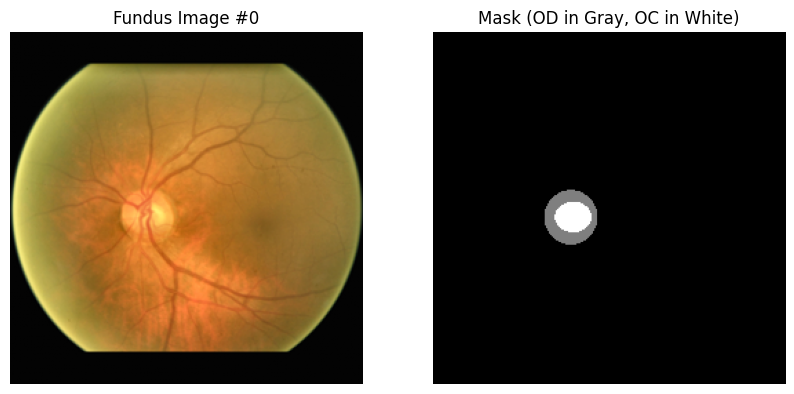

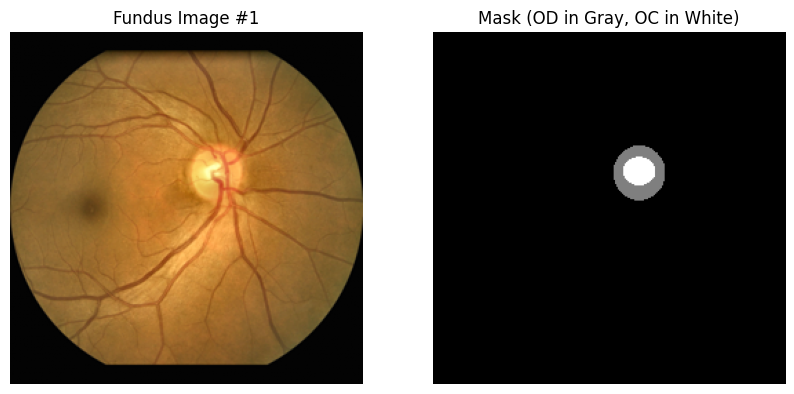

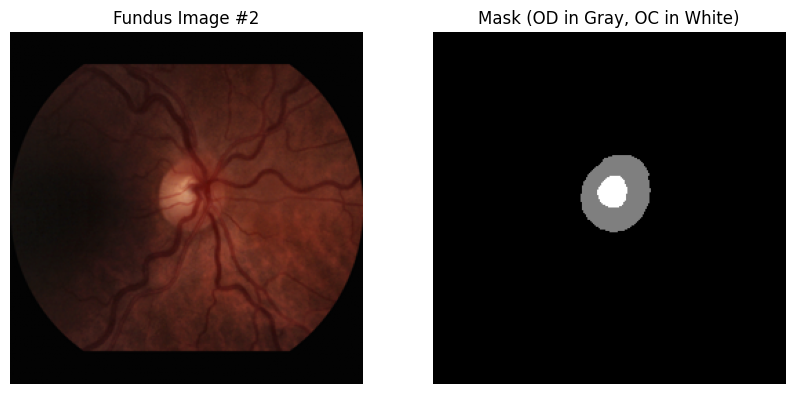

In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

# Base directory in Google Drive
base_dir = "/content/drive/MyDrive/Glaucoma detection"

fundus_dir = os.path.join(base_dir, "clahe_full_fundus")       # precomputed CLAHE images
oc_dir     = os.path.join(base_dir, "optic-cup/optic-cup")
od_dir     = os.path.join(base_dir, "optic-disc/optic-disc")

print("Base directory:", base_dir)
print("Fundus dir:", fundus_dir, "->", os.path.exists(fundus_dir))
print("OC dir    :", oc_dir, "->", os.path.exists(oc_dir))
print("OD dir    :", od_dir, "->", os.path.exists(od_dir))

# Image parameters
IMG_HEIGHT = 256
IMG_WIDTH  = 256
NUM_CLASSES = 3  # Background, Optic Disc (OD), Optic Cup (OC)

def load_and_preprocess_data(fundus_dir, oc_dir, od_dir, img_height, img_width, num_classes):
    images = []
    masks  = []
    skipped = 0
    used    = 0

    fundus_filenames = sorted(os.listdir(fundus_dir))
    print("Total CLAHE fundus images found:", len(fundus_filenames))

    for i, filename in enumerate(fundus_filenames):
        fundus_path = os.path.join(fundus_dir, filename)
        base_name   = os.path.splitext(filename)[0]

        # OC mask
        oc_path_png = os.path.join(oc_dir, base_name + ".png")
        oc_path_jpg = os.path.join(oc_dir, base_name + ".jpg")
        oc_path     = oc_path_png if os.path.exists(oc_path_png) else (oc_path_jpg if os.path.exists(oc_path_jpg) else None)

        # OD mask
        od_path_png = os.path.join(od_dir, base_name + ".png")
        od_path_jpg = os.path.join(od_dir, base_name + ".jpg")
        od_path     = od_path_png if os.path.exists(od_path_png) else (od_path_jpg if os.path.exists(od_path_jpg) else None)

        if not oc_path or not od_path:
            skipped += 1
            continue

        # Load fundus CLAHE image
        fundus_img = Image.open(fundus_path).convert("RGB")
        fundus_img = fundus_img.resize((img_width, img_height))
        fundus_img = np.array(fundus_img)
        images.append(fundus_img)

        # Load masks
        oc_mask = Image.open(oc_path).convert("L").resize((img_width, img_height))
        od_mask = Image.open(od_path).convert("L").resize((img_width, img_height))

        oc_mask = np.array(oc_mask)
        od_mask = np.array(od_mask)

        oc_mask = np.where(oc_mask > 0, 255, 0).astype(np.uint8)  # OC = white
        od_mask = np.where(od_mask > 0, 128, 0).astype(np.uint8)  # OD = gray

        combined_mask = np.maximum(oc_mask, od_mask)

        one_hot_mask = np.zeros((img_height, img_width, num_classes), dtype=np.float32)
        one_hot_mask[combined_mask == 0,   0] = 1  # Background
        one_hot_mask[combined_mask == 128, 1] = 1  # OD
        one_hot_mask[combined_mask == 255, 2] = 1  # OC

        masks.append(one_hot_mask)
        used += 1

        if i % 500 == 0:
            print(f"Processed {i}/{len(fundus_filenames)}")

    print(f"✅ Loaded {used} samples, ❌ Skipped {skipped} images due to missing masks.")
    return np.array(images), np.array(masks)

# Load dataset
X, Y = load_and_preprocess_data(fundus_dir, oc_dir, od_dir,
                                IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)

# Normalize images
X = X / 255.0

# Shuffle
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]

# Split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.15, random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"Y_test shape:  {Y_test.shape}")

# Visualize
def display_sample(image, mask, index):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Fundus Image #{index}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    mask_combined = np.argmax(mask, axis=-1)

    color_map = {0:(0,0,0), 1:(0.5,0.5,0.5), 2:(1,1,1)}
    mask_rgb = np.zeros((mask_combined.shape[0], mask_combined.shape[1], 3), dtype=np.float32)

    for label, color in color_map.items():
        mask_rgb[mask_combined == label] = color

    plt.imshow(mask_rgb)
    plt.title("Mask (OD in Gray, OC in White)")
    plt.axis("off")
    plt.show()

for i in range(3):
    display_sample(X_train[i], Y_train[i], i)


In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# ============================
# 1) Metrics: IoU & Dice
# ============================
@tf.function
def iou_metric(y_true, y_pred, num_classes=3):
    """
    Mean IoU over all classes (0 = background, 1 = OD, 2 = OC)
    """
    iou_scores = []
    y_true = tf.argmax(y_true, axis=-1)  # (B, H, W)
    y_pred = tf.argmax(y_pred, axis=-1)  # (B, H, W)

    for i in range(num_classes):
        intersection = tf.reduce_sum(
            tf.cast((y_true == i) & (y_pred == i), tf.float32)
        )
        union = tf.reduce_sum(
            tf.cast((y_true == i) | (y_pred == i), tf.float32)
        )
        iou = intersection / (union + tf.keras.backend.epsilon())
        iou_scores.append(iou)

    return tf.reduce_mean(iou_scores)


@tf.function
def dice_coefficient(y_true, y_pred, num_classes=3):
    """
    Mean Dice over all classes (0 = background, 1 = OD, 2 = OC)
    """
    dice_scores = []
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)

    for i in range(num_classes):
        intersection = tf.reduce_sum(
            tf.cast((y_true == i) & (y_pred == i), tf.float32)
        )
        union = tf.reduce_sum(
            tf.cast((y_true == i) | (y_pred == i), tf.float32)
        )
        dice = 2.0 * intersection / (union + intersection + tf.keras.backend.epsilon())
        dice_scores.append(dice)

    return tf.reduce_mean(dice_scores)


# ============================
# 2) Callbacks
# ============================
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'ocod_seg_smdg.h5',   # <- changed name for SMDG
    verbose=1,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        monitor='val_loss',
        restore_best_weights=True
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir='logs_unet_smdg'
    )
]

# ============================
# 3) Compile model
# ============================
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', iou_metric, dice_coefficient]
)

# ============================
# 4) Train
# ============================
results = model.fit(
    X_train,
    Y_train,
    validation_split=0.15,  # 15% of train used as val
    batch_size=64,           # you can push this higher on A100 if VRAM allows (16/32)
    epochs=100,
    callbacks=callbacks
)

# ============================
# 5) Evaluate on held-out test set
# ============================
evaluation = model.evaluate(X_test, Y_test)

print("\nEvaluation Results on TEST set:")
print(f"Test Loss:              {evaluation[0]:.4f}")
print(f"Test Accuracy:          {evaluation[1]:.4f}")
print(f"Test Mean IoU:          {evaluation[2]:.4f}")
print(f"Test Dice Coefficient:  {evaluation[3]:.4f}")


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 509ms/step - accuracy: 0.9900 - dice_coefficient: 0.7815 - iou_metric: 0.6730 - loss: 0.0267 - val_accuracy: 0.9928 - val_dice_coefficient: 0.8171 - val_iou_metric: 0.7133 - val_loss: 0.0176
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9926 - dice_coefficient: 0.8297 - iou_metric: 0.7293 - loss: 0.0181 - val_accuracy: 0.9929 - val_dice_coefficient: 0.8255 - val_iou_metric: 0.7233 - val_loss: 0.0175
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9933 - dice_coefficient: 0.8504 - iou_metric: 0.7557 - loss: 0.0160 - val_accuracy: 0.9937 - val_dice_coefficient: 0.8505 - val_iou_metric: 0.7557 - val_loss: 0.0151
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9937 - dice_coefficient: 0.8552 - iou_metric: 0.7620 - loss: 0.0151 - val_accuracy: 0.9937 - val_dice_coefficient: 0.8430 - val_iou_metric: 0.7462 - val_loss: 0.0157
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.

Epoch 1/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9927 - dice_coefficient: 0.8362 - iou_metric: 0.7399 - loss: 0.0196
Epoch 1: val_iou_metric improved from -inf to 0.71765, saving model to ocod_seg_smdg_best.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.9927 - dice_coefficient: 0.8362 - iou_metric: 0.7399 - loss: 0.0196 - val_accuracy: 0.9927 - val_dice_coefficient: 0.8182 - val_iou_metric: 0.7177 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 2/100
259/260 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9930 - dice_coefficient: 0.8404 - iou_metric: 0.7444 - loss: 0.0185
Epoch 2: val_iou_metric improved from 0.71765 to 0.72235, saving model to ocod_seg_smdg_best.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9930 - dice_coefficient: 0.8404 - iou_metric: 0.7444 - loss: 0.0185 - val_accuracy: 0.9927 - val_dice_coefficient: 0.8229 - val_iou_metric: 0.7224 - val_loss: 0.0178 - learning_rate: 0.0010
Epoch 3/100
258/260 ━━━━━━━━━━━━━━━━━━━━

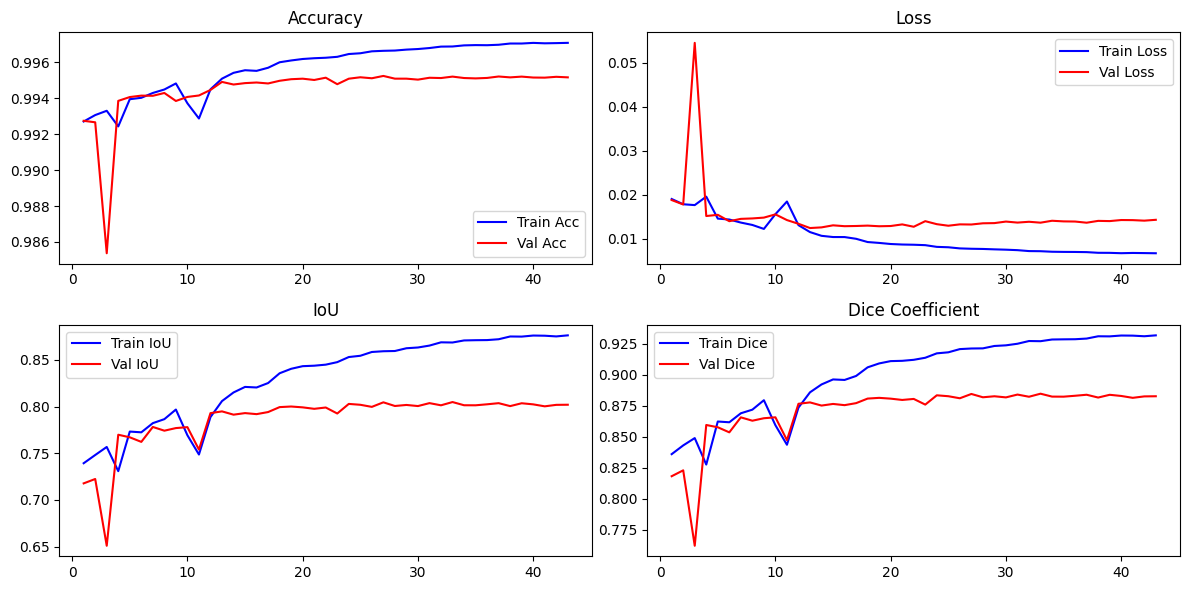


Saved:
 - Best checkpoint:          ocod_seg_smdg_best.keras
 - Final full model:         ocod_seg_smdg_full_model.keras
 - Final weights only:       ocod_seg_smdg.weights.h5


In [ ]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt

# ============================================================
# 1) Metrics: IoU & Dice for 3-class segmentation (BG, OD, OC)
# ============================================================

@tf.function
def iou_metric(y_true, y_pred, num_classes=3):
    iou_scores = []
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)

    for i in range(num_classes):
        intersection = tf.reduce_sum(tf.cast((y_true == i) & (y_pred == i), tf.float32))
        union = tf.reduce_sum(tf.cast((y_true == i) | (y_pred == i), tf.float32))
        iou = intersection / (union + tf.keras.backend.epsilon())
        iou_scores.append(iou)

    return tf.reduce_mean(iou_scores)


@tf.function
def dice_coefficient(y_true, y_pred, num_classes=3):
    dice_scores = []
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)

    for i in range(num_classes):
        intersection = tf.reduce_sum(tf.cast((y_true == i) & (y_pred == i), tf.float32))
        union = tf.reduce_sum(tf.cast((y_true == i) | (y_pred == i), tf.float32))
        dice = 2.0 * intersection / (union + intersection + tf.keras.backend.epsilon())
        dice_scores.append(dice)

    return tf.reduce_mean(dice_scores)


# ============================================================
# 2) Callbacks
# ============================================================

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'ocod_seg_smdg_best.keras',    # recommended format
    monitor='val_iou_metric',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_dice_coefficient',
    mode='max',
    verbose=1,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_iou_metric',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    mode='max',
    verbose=1
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs_unet_smdg')

callbacks = [early_stopping, checkpointer, reduce_lr, tensorboard_callback]


# ============================================================
# 3) Compile
# ============================================================

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', iou_metric, dice_coefficient]
)


# ============================================================
# 4) Train + time tracking
# ============================================================

start_time = time.time()

results = model.fit(
    X_train,
    Y_train,
    validation_split=0.15,
    batch_size=8,
    epochs=100,
    callbacks=callbacks
)

end_time = time.time()
training_time = end_time - start_time


# ============================================================
# 5) Evaluate
# ============================================================

evaluation = model.evaluate(X_test, Y_test, verbose=1)

print("\n===== Evaluation =====")
print(f"Training Time:         {training_time:.2f} sec")
print(f"Test Loss:             {evaluation[0]:.4f}")
print(f"Test Accuracy:         {evaluation[1]:.4f}")
print(f"Test IoU:              {evaluation[2]:.4f}")
print(f"Test Dice Coefficient: {evaluation[3]:.4f}")


# ============================================================
# 6) Training Curves
# ============================================================

def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'b', label='Train Acc')
    plt.plot(epochs, history.history['val_accuracy'], 'r', label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b', label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(2, 2, 3)
    plt.plot(epochs, history.history['iou_metric'], 'b', label='Train IoU')
    plt.plot(epochs, history.history['val_iou_metric'], 'r', label='Val IoU')
    plt.legend()
    plt.title('IoU')

    plt.subplot(2, 2, 4)
    plt.plot(epochs, history.history['dice_coefficient'], 'b', label='Train Dice')
    plt.plot(epochs, history.history['val_dice_coefficient'], 'r', label='Val Dice')
    plt.legend()
    plt.title('Dice Coefficient')

    plt.tight_layout()
    plt.show()

plot_training_history(results)


# ============================================================
# 7) Save Full Model + Weights
# ============================================================

# Recommended:
model.save("ocod_seg_smdg_full_model.keras")

# Weights ONLY (must end in .weights.h5)
model.save_weights("ocod_seg_smdg.weights.h5")

print("\nSaved:")
print(" - Best checkpoint:          ocod_seg_smdg_best.keras")
print(" - Final full model:         ocod_seg_smdg_full_model.keras")
print(" - Final weights only:       ocod_seg_smdg.weights.h5")


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step


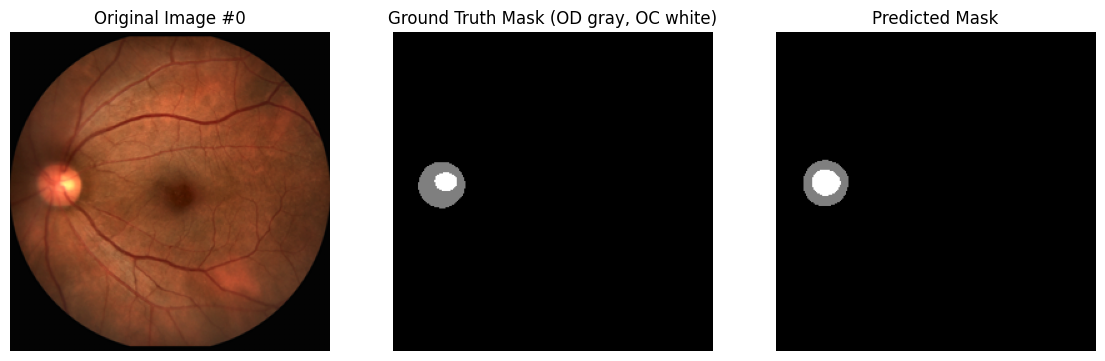

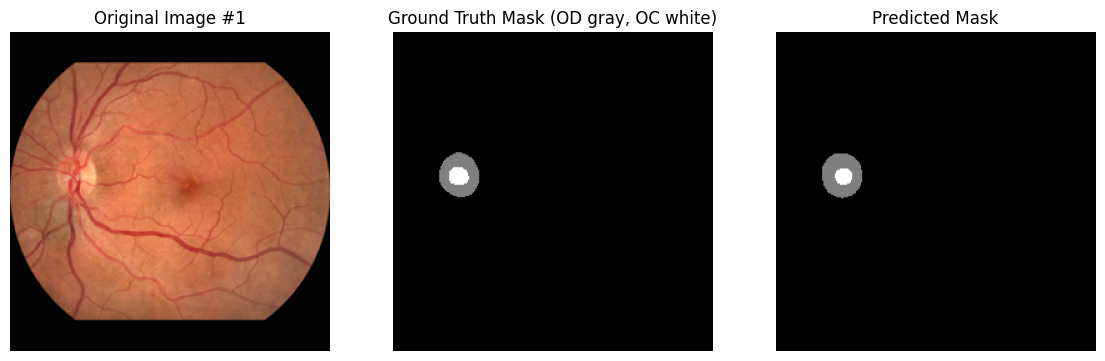

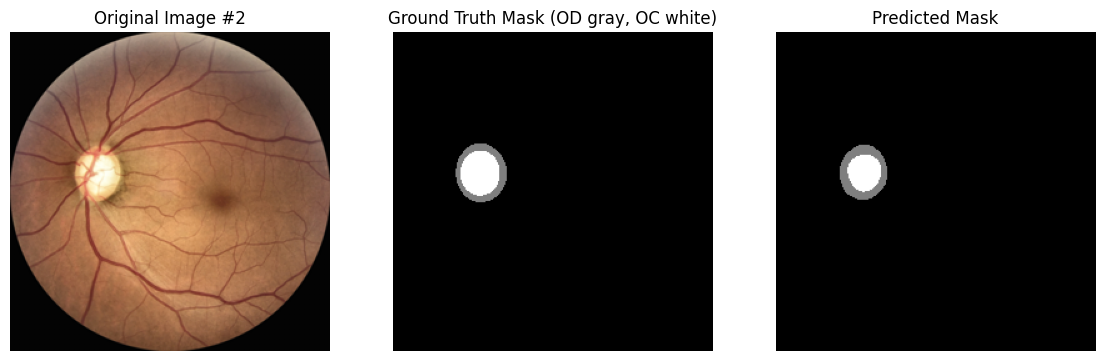

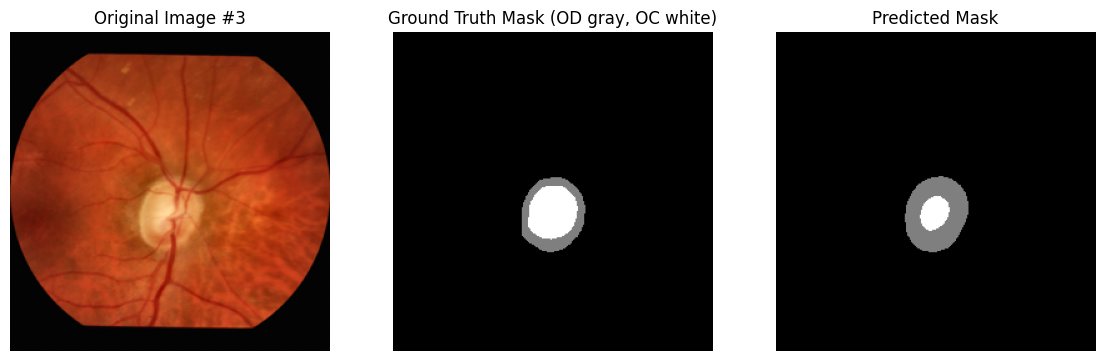

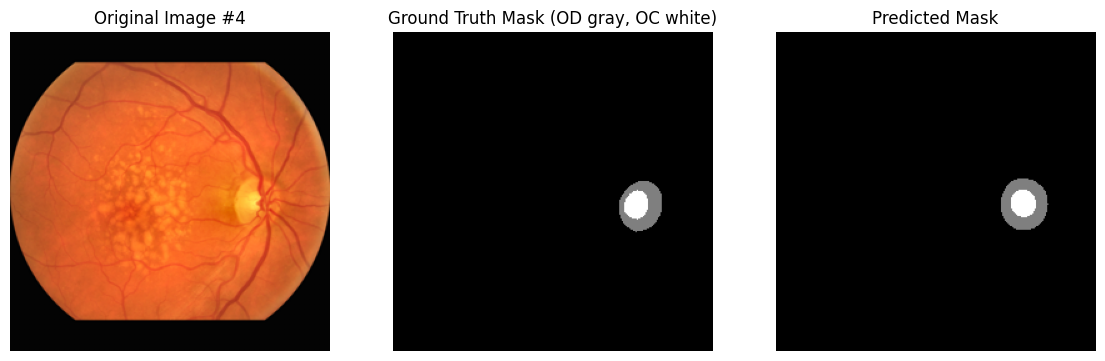

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# Function to decode a one-hot OR predicted mask to RGB
# --------------------------------------------------------
def decode_mask(mask_3d):
    """
    mask_3d: one-hot ground truth OR softmax prediction (H,W,3)
    """
    mask = np.argmax(mask_3d, axis=-1)  # convert to (H, W)

    # 3-class color map
    color_map = {
        0: (0.0, 0.0, 0.0),      # Background - black
        1: (0.5, 0.5, 0.5),      # OD - gray
        2: (1.0, 1.0, 1.0)       # OC - white
    }

    h, w = mask.shape
    mask_rgb = np.zeros((h, w, 3))

    for label, color in color_map.items():
        mask_rgb[mask == label] = color

    return mask_rgb


# --------------------------------------------------------
# Display Image + GT Mask + Predicted Mask side by side
# --------------------------------------------------------
def display_result(image, gt_mask, pred_mask, index):
    plt.figure(figsize=(14, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Original Image #{index}")
    plt.axis("off")

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(decode_mask(gt_mask))
    plt.title("Ground Truth Mask (OD gray, OC white)")
    plt.axis("off")

    # Predicted mask (decoded)
    plt.subplot(1, 3, 3)
    plt.imshow(decode_mask(pred_mask))
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


# --------------------------------------------------------
# Run prediction on test set
# --------------------------------------------------------
Y_pred = model.predict(X_test)

# --------------------------------------------------------
# Visualize first 5 predictions
# --------------------------------------------------------
for i in range(5):
    display_result(X_test[i], Y_test[i], Y_pred[i], i)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


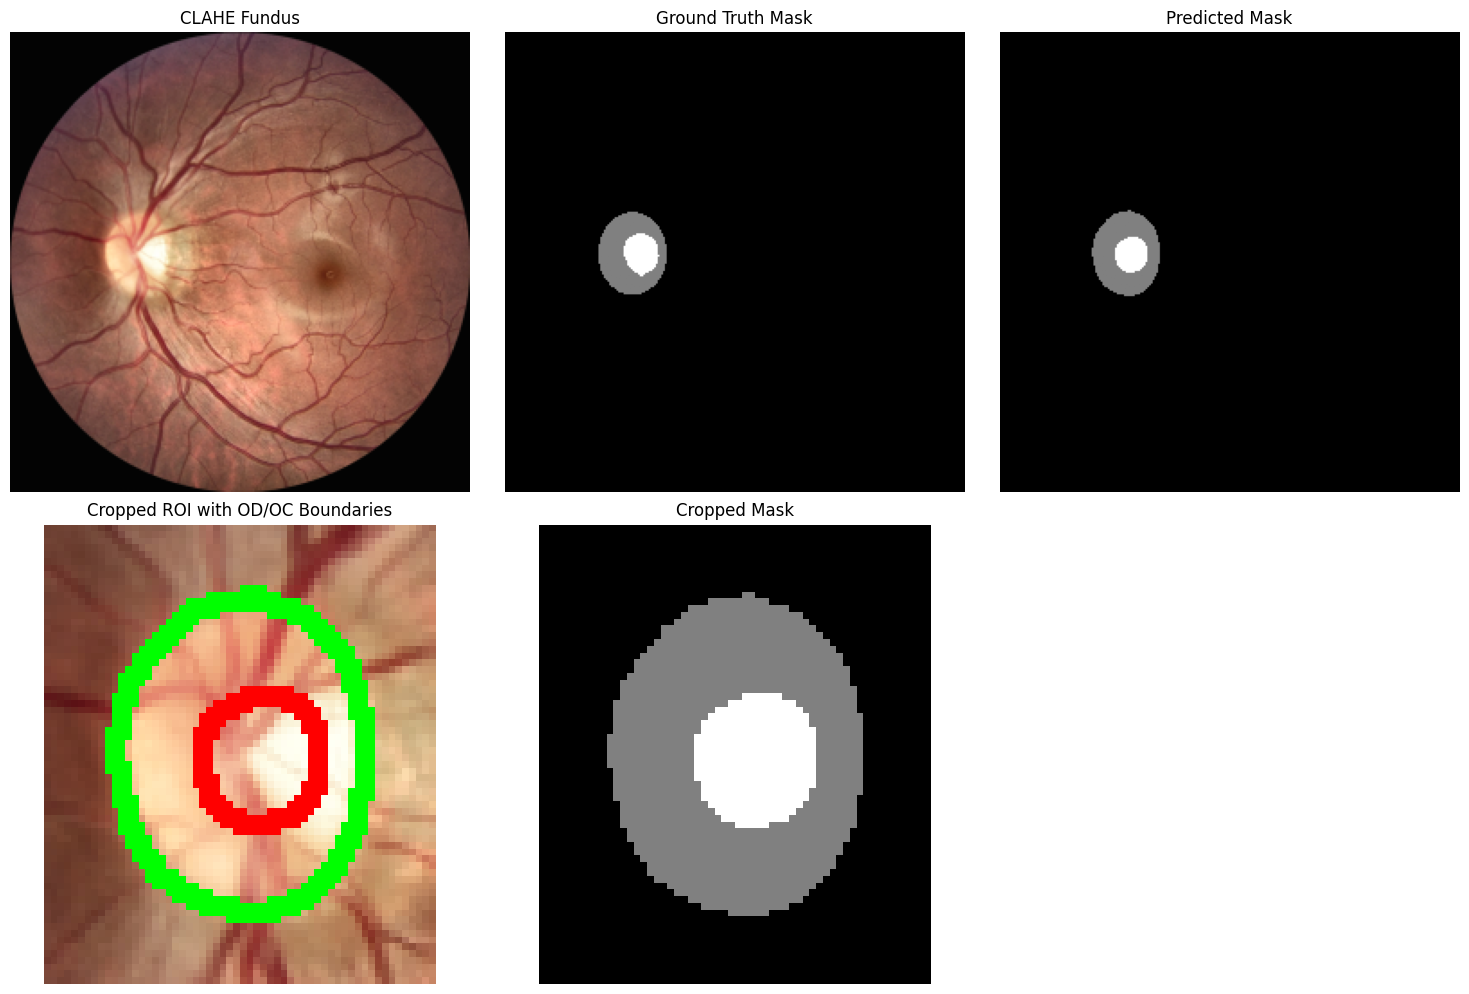

In [ ]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(image_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img.astype("float32") / 255.0
    return np.expand_dims(img, axis=0)


def predict_image_segmentation(model, img_path):
    img = load_and_preprocess_image(img_path)
    pred = model.predict(img)
    return np.argmax(pred, axis=-1)[0]  # (H,W)


# ----------------------------------------------------------
# 4. LOAD OC + OD MASKS (SMDG)
# ----------------------------------------------------------
def load_ground_truth_mask_smdg(base_name):

    # OC
    oc_png = os.path.join(oc_dir, base_name + ".png")
    oc_jpg = os.path.join(oc_dir, base_name + ".jpg")
    oc_path = oc_png if os.path.exists(oc_png) else oc_jpg

    # OD
    od_png = os.path.join(od_dir, base_name + ".png")
    od_jpg = os.path.join(od_dir, base_name + ".jpg")
    od_path = od_png if os.path.exists(od_png) else od_jpg

    if oc_path is None or od_path is None:
        raise FileNotFoundError("Missing OC/OD mask for " + base_name)

    oc = cv2.imread(oc_path, cv2.IMREAD_GRAYSCALE)
    od = cv2.imread(od_path, cv2.IMREAD_GRAYSCALE)

    oc = cv2.resize(oc, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    od = cv2.resize(od, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

    oc_bin = (oc > 0).astype(np.uint8)
    od_bin = (od > 0).astype(np.uint8)

    final = np.zeros_like(oc_bin)
    final[od_bin == 1] = 1
    final[oc_bin == 1] = 2
    return final


# ----------------------------------------------------------
# 5. ROI EXTRACTION WITH BOUNDARIES
# ----------------------------------------------------------
def extract_roi_with_boundaries(img, pred_mask):

    mask = pred_mask.copy()

    if 1 not in np.unique(mask) or 2 not in np.unique(mask):
        return None, None

    # OD and OC contours
    cont_od, _ = cv2.findContours((mask == 1).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cont_oc, _ = cv2.findContours((mask == 2).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not cont_od or not cont_oc:
        return None, None

    od = max(cont_od, key=cv2.contourArea)
    oc = max(cont_oc, key=cv2.contourArea)

    od_x, od_y, od_w, od_h = cv2.boundingRect(od)
    oc_x, oc_y, oc_w, oc_h = cv2.boundingRect(oc)

    x_min = max(min(od_x, oc_x) - 10, 0)
    y_min = max(min(od_y, oc_y) - 10, 0)
    x_max = min(max(od_x + od_w, oc_x + oc_w) + 10, IMG_WIDTH)
    y_max = min(max(od_y + od_h, oc_y + oc_h) + 10, IMG_HEIGHT)

    crop_img  = img[y_min:y_max, x_min:x_max].copy()
    crop_mask = mask[y_min:y_max, x_min:x_max].copy()

    od_shift = od - np.array([[x_min, y_min]])
    oc_shift = oc - np.array([[x_min, y_min]])

    cv2.drawContours(crop_img, [od_shift], -1, (0,255,0), 2)
    cv2.drawContours(crop_img, [oc_shift], -1, (255,0,0), 2)

    return crop_img, crop_mask


# ----------------------------------------------------------
# 6. DISPLAY EVERYTHING
# ----------------------------------------------------------
def visualize_sample(base_name):

    # FUNDUS FROM CLAHE DIRECTORY
    f_png = os.path.join(fundus_dir, base_name + ".png")
    f_jpg = os.path.join(fundus_dir, base_name + ".jpg")
    f_path = f_png if os.path.exists(f_png) else f_jpg

    if not os.path.exists(f_path):
        raise FileNotFoundError("CLAHE fundus missing: " + base_name)

    f_img = cv2.imread(f_path)
    f_img = cv2.cvtColor(f_img, cv2.COLOR_BGR2RGB)
    f_resized = cv2.resize(f_img, (IMG_WIDTH, IMG_HEIGHT))

    gt_mask   = load_ground_truth_mask_smdg(base_name)
    pred_mask = predict_image_segmentation(model, f_path)

    crop_f, crop_m = extract_roi_with_boundaries(f_resized, pred_mask)

    plt.figure(figsize=(15,10))

    plt.subplot(2,3,1)
    plt.imshow(f_resized)
    plt.title("CLAHE Fundus")
    plt.axis("off")

    plt.subplot(2,3,2)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(2,3,3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    if crop_f is not None:
        plt.subplot(2,3,4)
        plt.imshow(crop_f)
        plt.title("Cropped ROI with OD/OC Boundaries")
        plt.axis("off")

        plt.subplot(2,3,5)
        plt.imshow(crop_m, cmap="gray")
        plt.title("Cropped Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------
# 7. RUN VISUALIZATION ON YOUR SAMPLES
# ----------------------------------------------------------
visualize_sample("REFUGE1-val-202")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


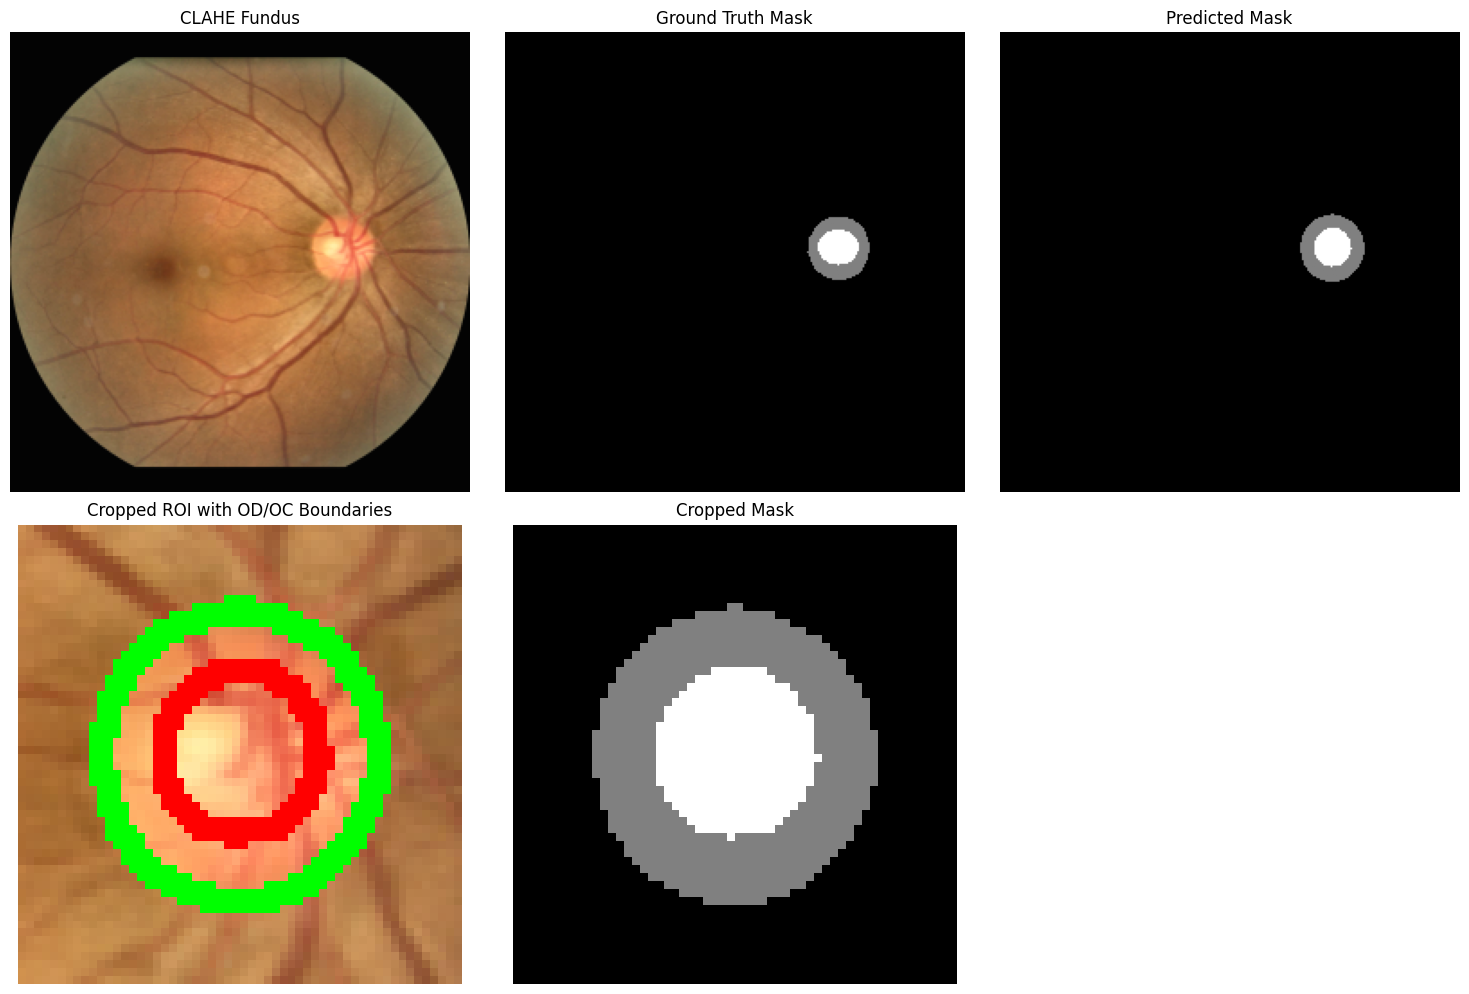

In [ ]:
visualize_sample("ORIGA-380")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


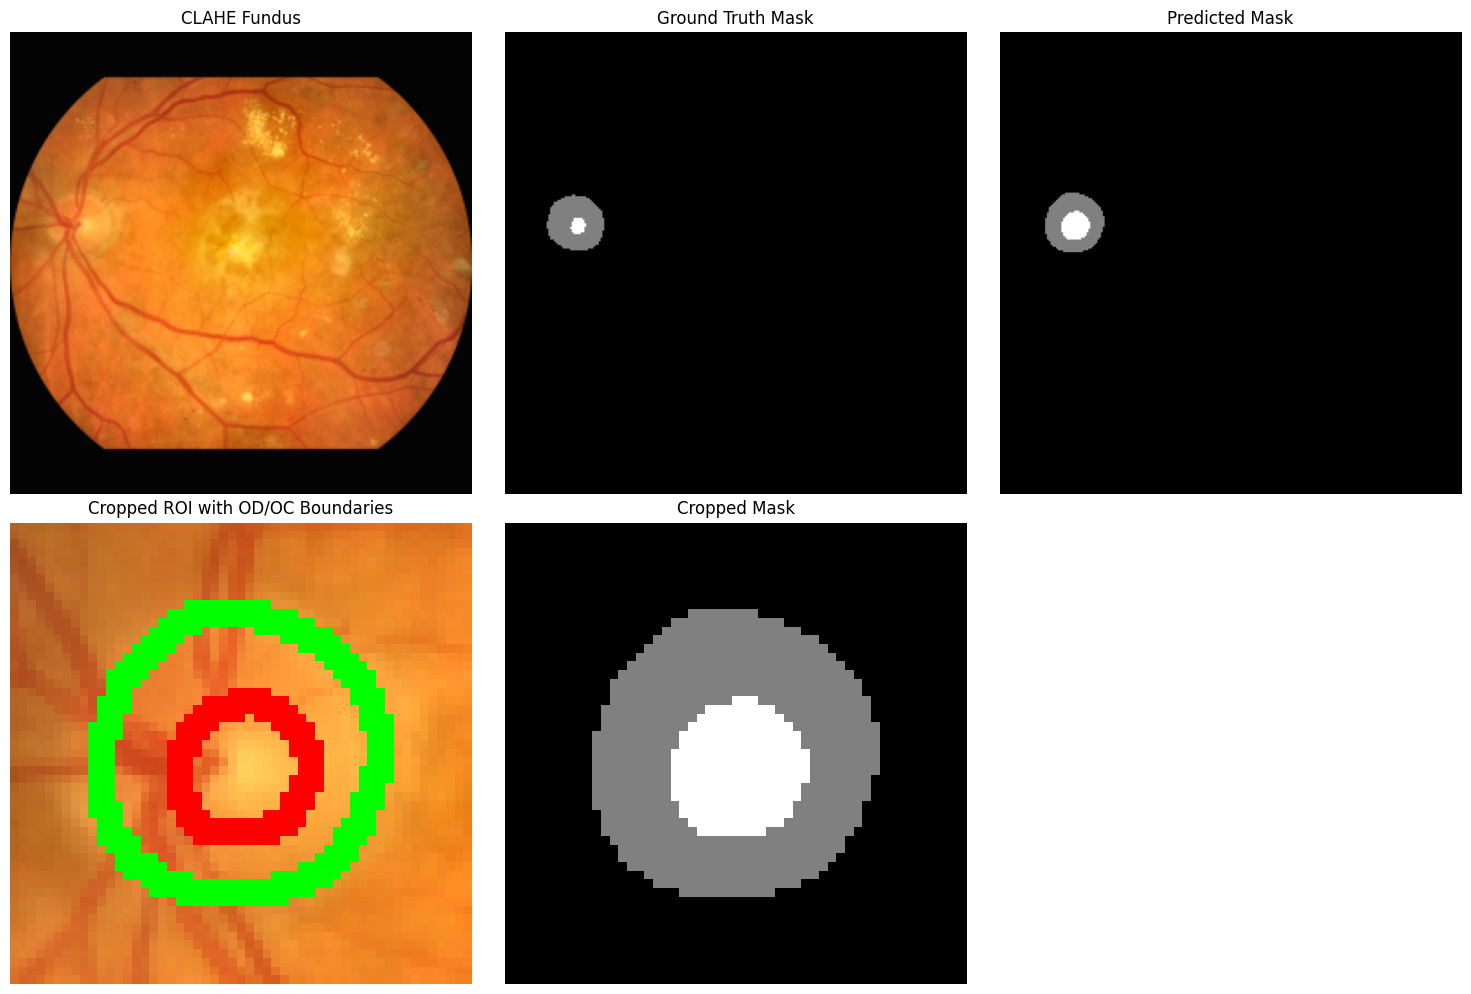

In [ ]:
visualize_sample("G1020-897")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


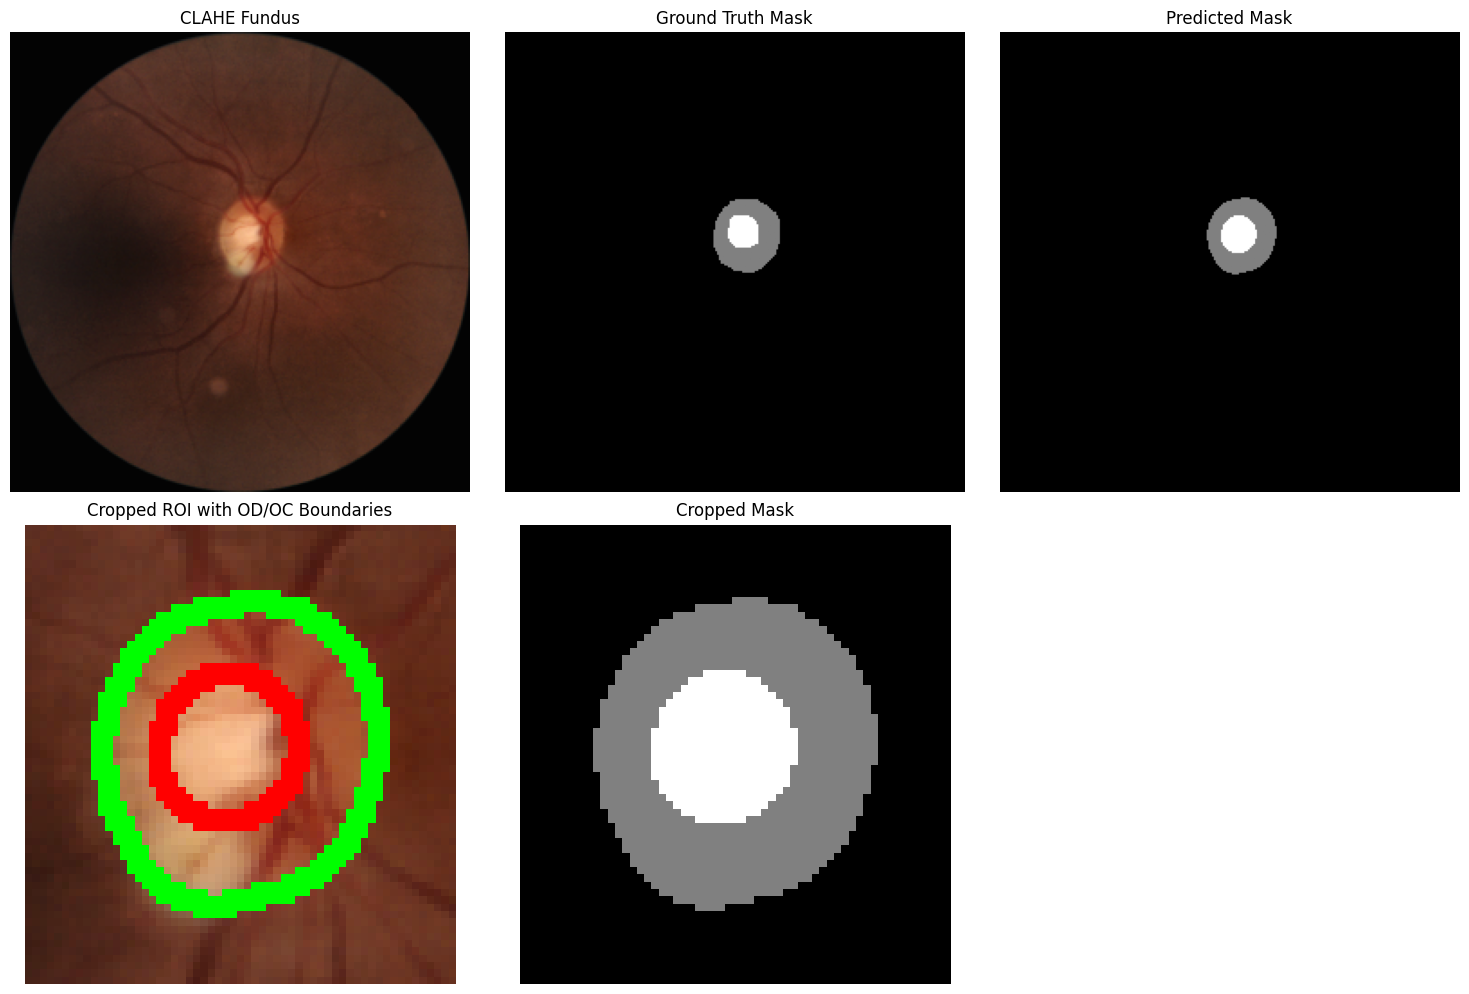

In [ ]:
visualize_sample("CRFO-v4-5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


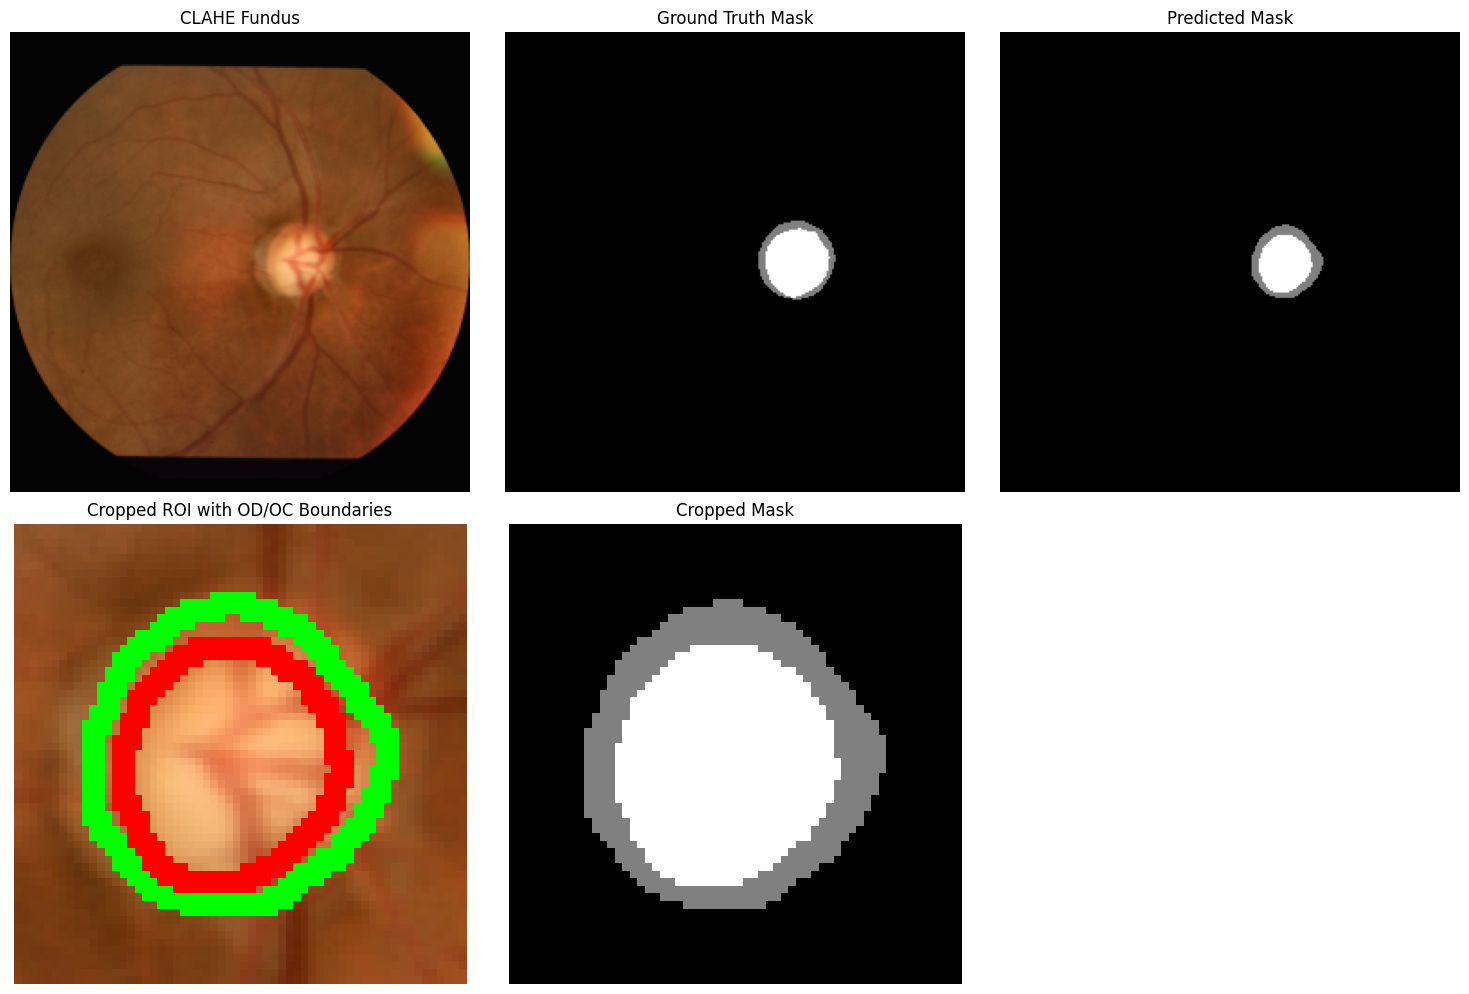

In [ ]:
visualize_sample("DRISHTI-GS1-test-27")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


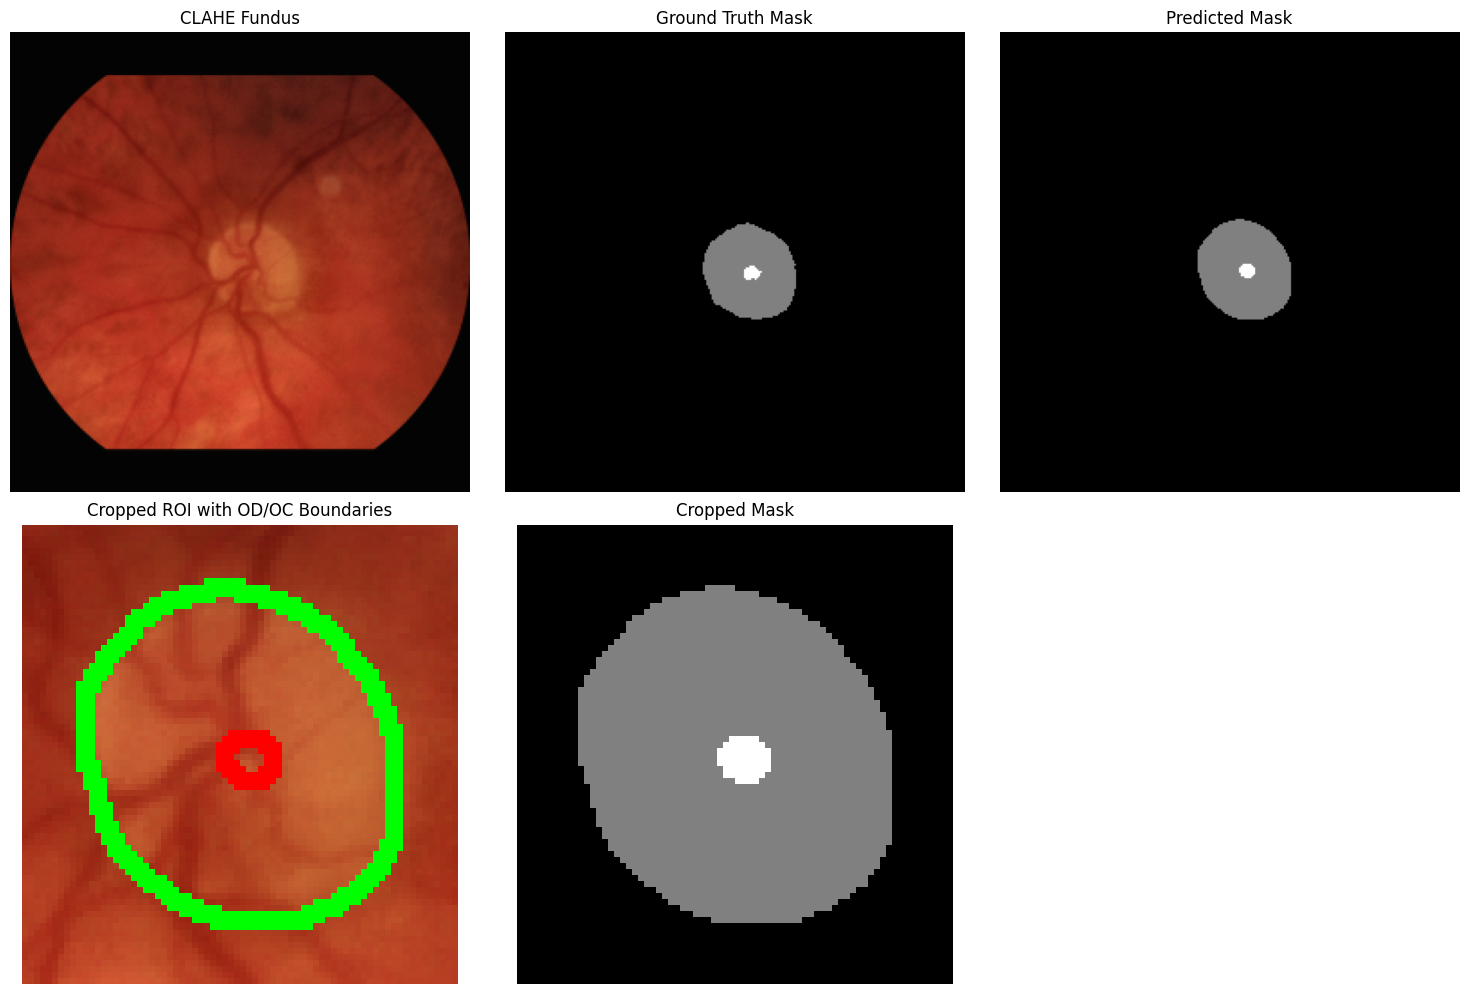

In [ ]:
visualize_sample("PAPILA-317")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


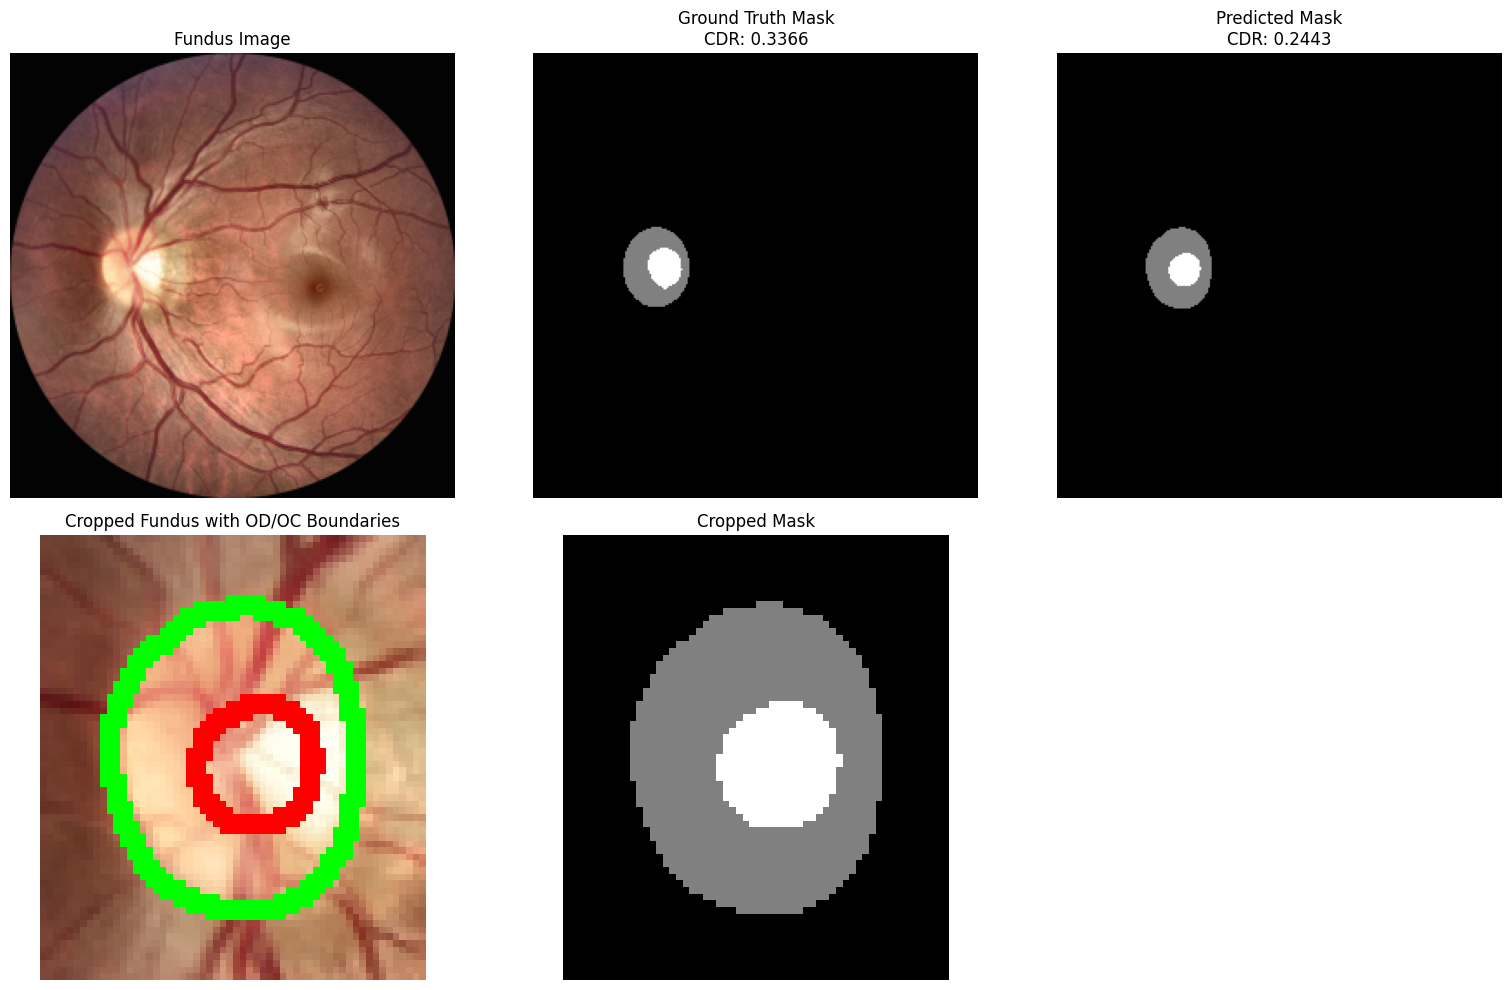

In [ ]:
def calculate_cdr(mask):
    """
    Calculate Cup-to-Disc Ratio (CDR) from a mask with:
      1: Optic Disc (OD)
      2: Optic Cup (OC)
    """
    mask = np.array(mask)
    od_area = np.sum(mask == 1)
    oc_area = np.sum(mask == 2)

    if od_area == 0:
        return 0.0

    cdr = oc_area / od_area
    return round(float(cdr), 4)


# ----------------------------------------------------------
# 2. OPTIONAL CLAHE (same as training, if used)
# ----------------------------------------------------------
def apply_clahe(image_rgb):
    lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    clahe_rgb = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    return clahe_rgb


# ----------------------------------------------------------
# 3. LOAD GT MASK FROM SMDG OD/OC MASKS
# ----------------------------------------------------------
def load_ground_truth_mask_smdg(base_name, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    base_name: e.g. "REFUGE1-val-202"
    OD: optic-disc/optic-disc/<base_name>.png|.jpg
    OC: optic-cup/optic-cup/<base_name>.png|.jpg

    Returns: HxW mask with values {0:BG, 1:OD, 2:OC}
    """
    def find_mask_path(mask_dir):
        png_path = os.path.join(mask_dir, base_name + ".png")
        jpg_path = os.path.join(mask_dir, base_name + ".jpg")
        if os.path.exists(png_path):
            return png_path
        if os.path.exists(jpg_path):
            return jpg_path
        return None

    od_path = find_mask_path(od_dir)
    oc_path = find_mask_path(oc_dir)

    if od_path is None or oc_path is None:
        raise FileNotFoundError(f"Missing OD/OC mask for {base_name}\nOD: {od_path}\nOC: {oc_path}")

    od_mask = cv2.imread(od_path, cv2.IMREAD_GRAYSCALE)
    oc_mask = cv2.imread(oc_path, cv2.IMREAD_GRAYSCALE)

    od_mask = cv2.resize(od_mask, target_size, interpolation=cv2.INTER_NEAREST)
    oc_mask = cv2.resize(oc_mask, target_size, interpolation=cv2.INTER_NEAREST)

    od_bin = (od_mask > 0).astype(np.uint8)
    oc_bin = (oc_mask > 0).astype(np.uint8)

    combined = np.zeros_like(od_bin, dtype=np.uint8)
    combined[od_bin == 1] = 1  # OD
    combined[oc_bin == 1] = 2  # OC overwrites OD

    return combined


# ----------------------------------------------------------
# 4. LOAD & PREPROCESS IMAGE FOR MODEL
# ----------------------------------------------------------
def load_and_preprocess_image(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Could not load fundus image: {image_path}")

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, target_size)

    # 👉 If your model was trained on CLAHE-processed inputs,
    # leave this ON. If you trained directly on original fundus pixels,
    # you can comment the next line out.
    img_rgb = apply_clahe(img_rgb)

    img_rgb = img_rgb.astype("float32") / 255.0
    img_rgb = np.expand_dims(img_rgb, axis=0)  # (1,H,W,3)
    return img_rgb


def predict_image_segmentation(model, image_path):
    x = load_and_preprocess_image(image_path)
    pred = model.predict(x)
    pred_mask = np.argmax(pred, axis=-1)  # (1,H,W)
    return pred_mask[0]                   # (H,W)


# ----------------------------------------------------------
# 5. ROI EXTRACTION WITH OD/OC BOUNDARIES
# ----------------------------------------------------------
def extract_roi_with_boundaries(fundus_image, predicted_mask):
    """
    fundus_image: HxWx3 RGB
    predicted_mask: HxW with {0,1,2}
    """
    H, W = fundus_image.shape[:2]

    if predicted_mask.shape[:2] != (H, W):
        predicted_mask = cv2.resize(
            predicted_mask.astype(np.uint8),
            (W, H),
            interpolation=cv2.INTER_NEAREST
        )

    mask = predicted_mask

    if 1 not in np.unique(mask) or 2 not in np.unique(mask):
        return None, None

    contours_od, _ = cv2.findContours((mask == 1).astype(np.uint8),
                                      cv2.RETR_EXTERNAL,
                                      cv2.CHAIN_APPROX_SIMPLE)
    contours_oc, _ = cv2.findContours((mask == 2).astype(np.uint8),
                                      cv2.RETR_EXTERNAL,
                                      cv2.CHAIN_APPROX_SIMPLE)

    if not contours_od or not contours_oc:
        return None, None

    od_contour = max(contours_od, key=cv2.contourArea)
    oc_contour = max(contours_oc, key=cv2.contourArea)

    od_x, od_y, od_w, od_h = cv2.boundingRect(od_contour)
    oc_x, oc_y, oc_w, oc_h = cv2.boundingRect(oc_contour)

    x_min = max(min(od_x, oc_x) - 10, 0)
    y_min = max(min(od_y, oc_y) - 10, 0)
    x_max = min(max(od_x + od_w, oc_x + oc_w) + 10, W)
    y_max = min(max(od_y + od_h, oc_y + oc_h) + 10, H)

    cropped_fundus = fundus_image[y_min:y_max, x_min:x_max].copy()
    cropped_mask   = mask[y_min:y_max, x_min:x_max].copy()

    od_shift = od_contour - np.array([[x_min, y_min]])
    oc_shift = oc_contour - np.array([[x_min, y_min]])

    cv2.drawContours(cropped_fundus, [od_shift], -1, (0, 255, 0), 2)   # OD: green
    cv2.drawContours(cropped_fundus, [oc_shift], -1, (255, 0, 0), 2)   # OC: blue

    return cropped_fundus, cropped_mask


# ----------------------------------------------------------
# 6. FULL VISUALIZATION (FUNDUS + GT + PRED + CDR + ROI)
# ----------------------------------------------------------
def display_images_and_masks_with_cdr_and_roi(base_name):
    """
    base_name: e.g. 'REFUGE1-val-202'
    """

    # 1) Resolve fundus path (CLAHE or original, depending on fundus_dir)
    f_png = os.path.join(fundus_dir, base_name + ".png")
    f_jpg = os.path.join(fundus_dir, base_name + ".jpg")
    fundus_image_path = f_png if os.path.exists(f_png) else f_jpg

    if not os.path.exists(fundus_image_path):
        raise FileNotFoundError("Fundus image not found for: " + base_name)

    # Load original fundus image for display
    fundus_bgr = cv2.imread(fundus_image_path)
    fundus_image = cv2.cvtColor(fundus_bgr, cv2.COLOR_BGR2RGB)
    fundus_image = cv2.resize(fundus_image, (IMG_WIDTH, IMG_HEIGHT))

    # Ground truth mask (0=BG,1=OD,2=OC)
    ground_truth_mask = load_ground_truth_mask_smdg(base_name)

    # Predicted mask
    predicted_mask = predict_image_segmentation(model, fundus_image_path)

    # CDRs
    gt_cdr   = calculate_cdr(ground_truth_mask)
    pred_cdr = calculate_cdr(predicted_mask)

    # ROI
    cropped_fundus, cropped_mask = extract_roi_with_boundaries(fundus_image, predicted_mask)

    # Plot
    plt.figure(figsize=(16, 10))

    # Fundus image
    plt.subplot(2, 3, 1)
    plt.imshow(fundus_image)
    plt.title("Fundus Image")
    plt.axis("off")

    # Ground truth mask + CDR
    plt.subplot(2, 3, 2)
    plt.imshow(ground_truth_mask, cmap="gray")
    plt.title(f"Ground Truth Mask\nCDR: {gt_cdr}")
    plt.axis("off")

    # Predicted mask + CDR
    plt.subplot(2, 3, 3)
    plt.imshow(predicted_mask, cmap="gray")
    plt.title(f"Predicted Mask\nCDR: {pred_cdr}")
    plt.axis("off")

    # Cropped ROI + boundaries
    if cropped_fundus is not None:
        plt.subplot(2, 3, 4)
        plt.imshow(cropped_fundus)
        plt.title("Cropped Fundus with OD/OC Boundaries")
        plt.axis("off")

        plt.subplot(2, 3, 5)
        plt.imshow(cropped_mask, cmap="gray")
        plt.title("Cropped Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------
# 7. RUN IT ON A SAMPLE
# ----------------------------------------------------------
display_images_and_masks_with_cdr_and_roi("REFUGE1-val-202")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


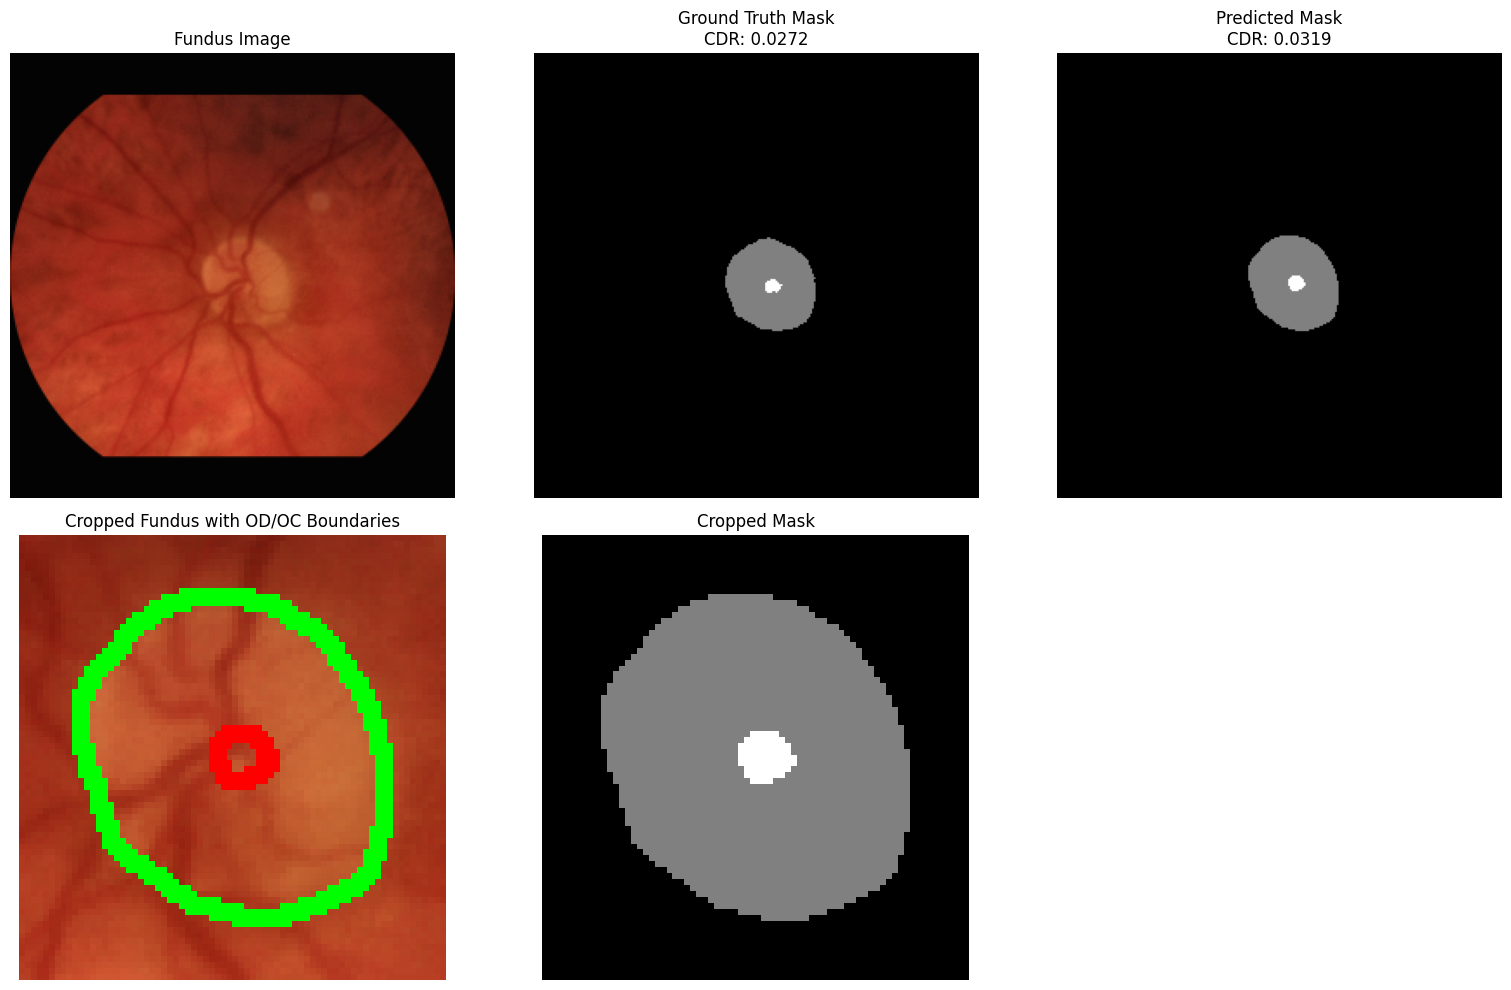

In [ ]:
display_images_and_masks_with_cdr_and_roi("PAPILA-317")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


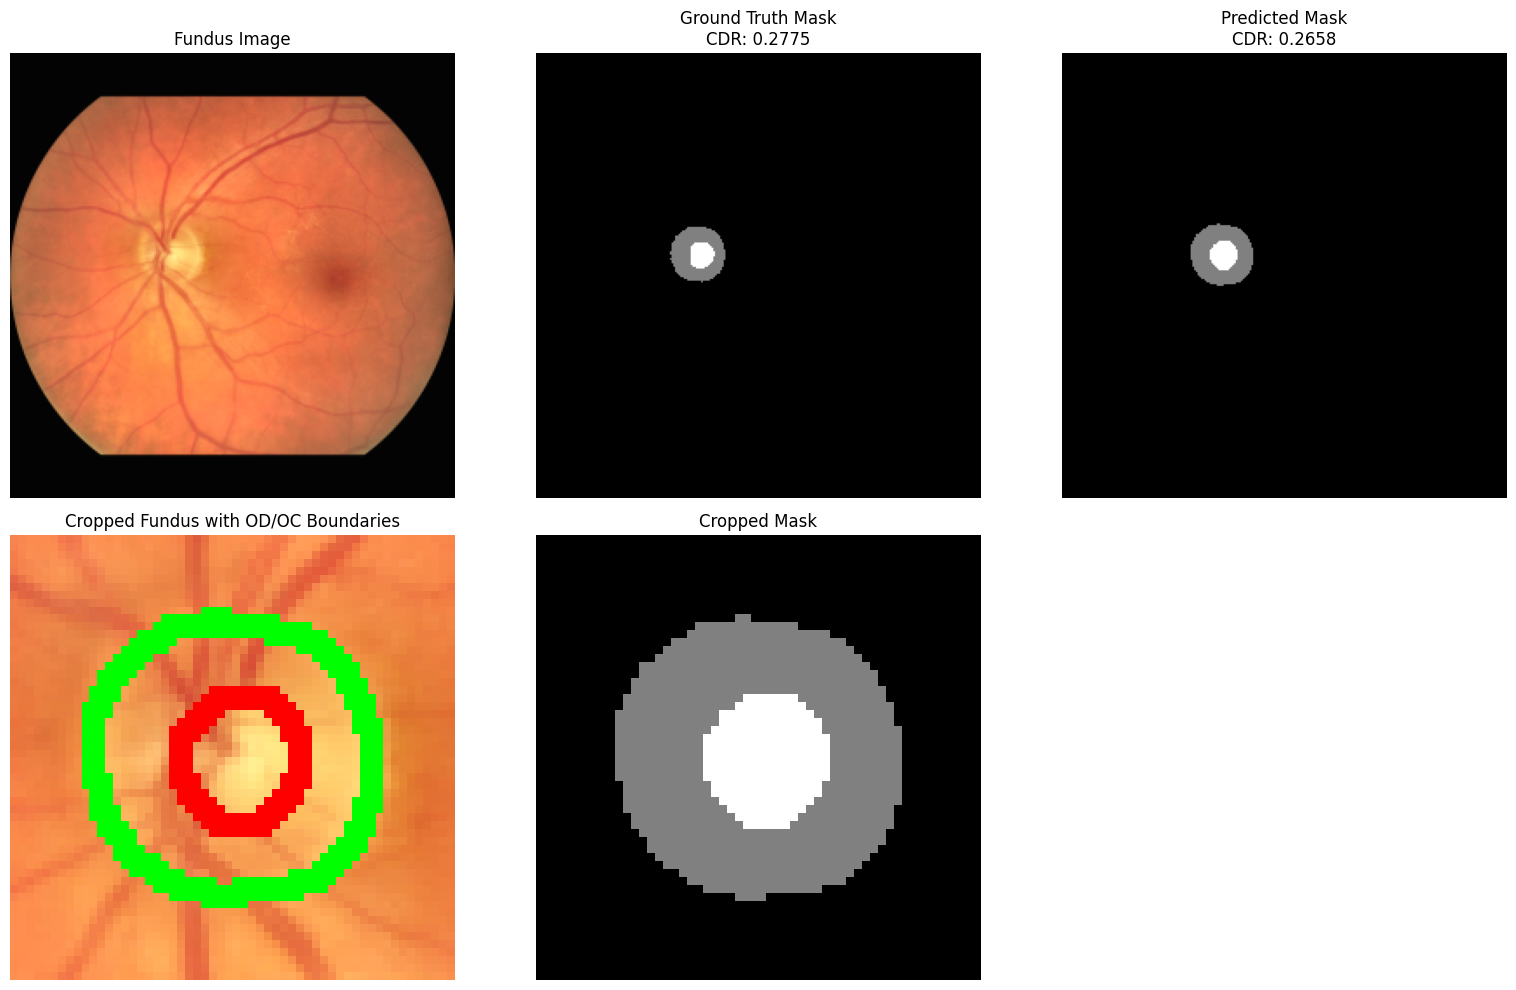

In [ ]:
display_images_and_masks_with_cdr_and_roi("G1020-371")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


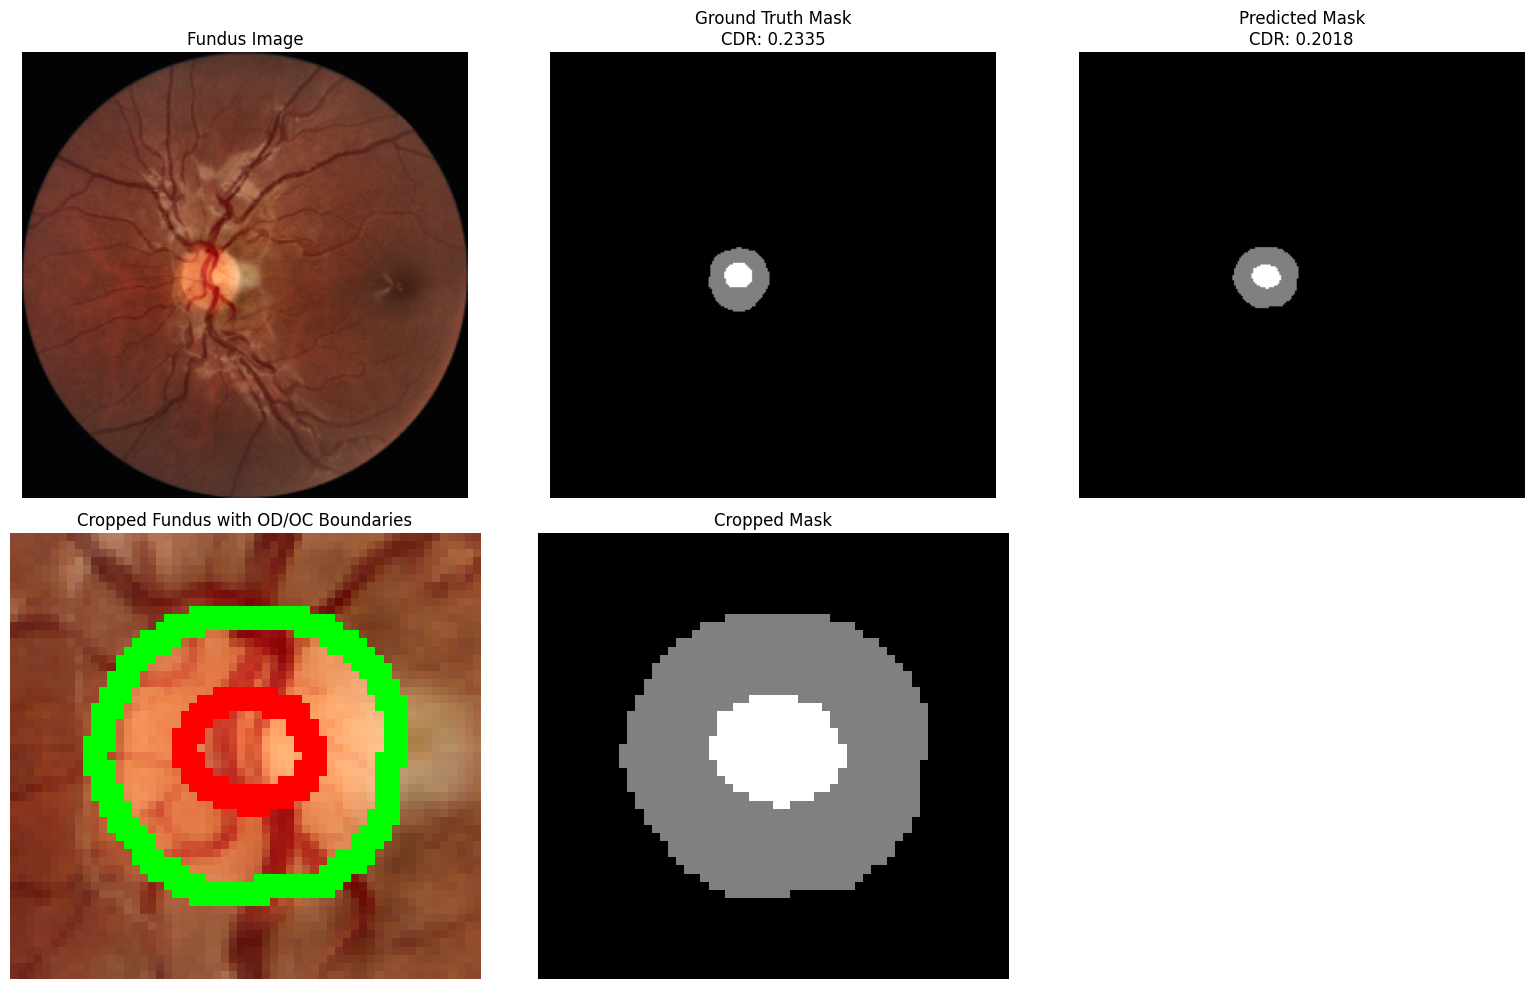

In [ ]:
display_images_and_masks_with_cdr_and_roi("CRFO-v4-47")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


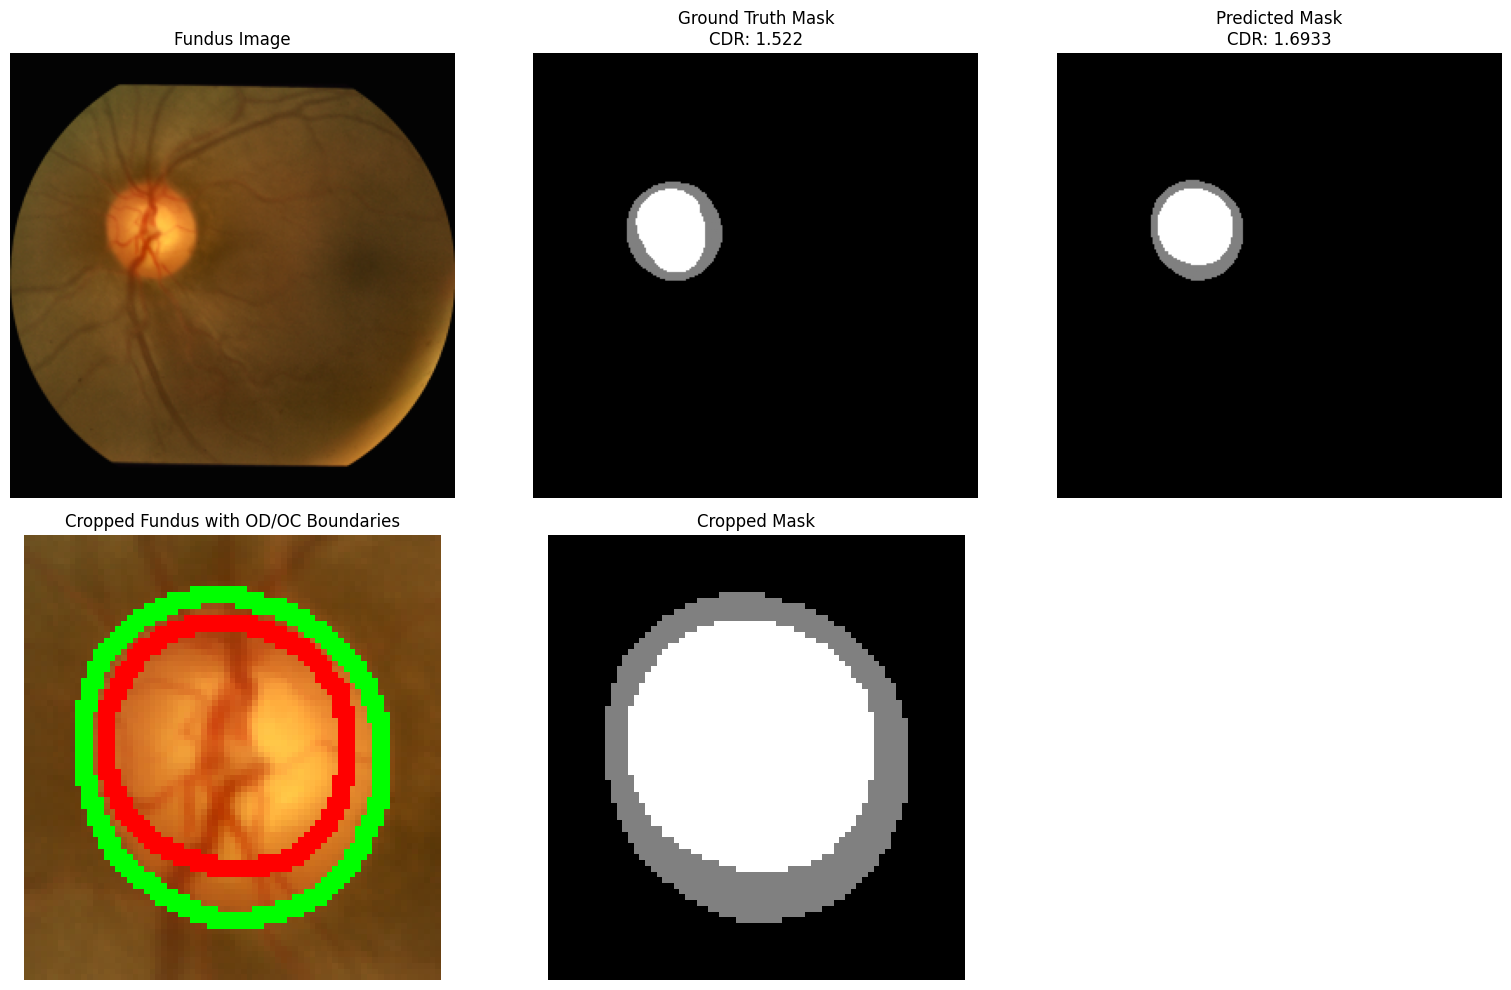

In [ ]:
display_images_and_masks_with_cdr_and_roi("DRISHTI-GS1-test-22")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


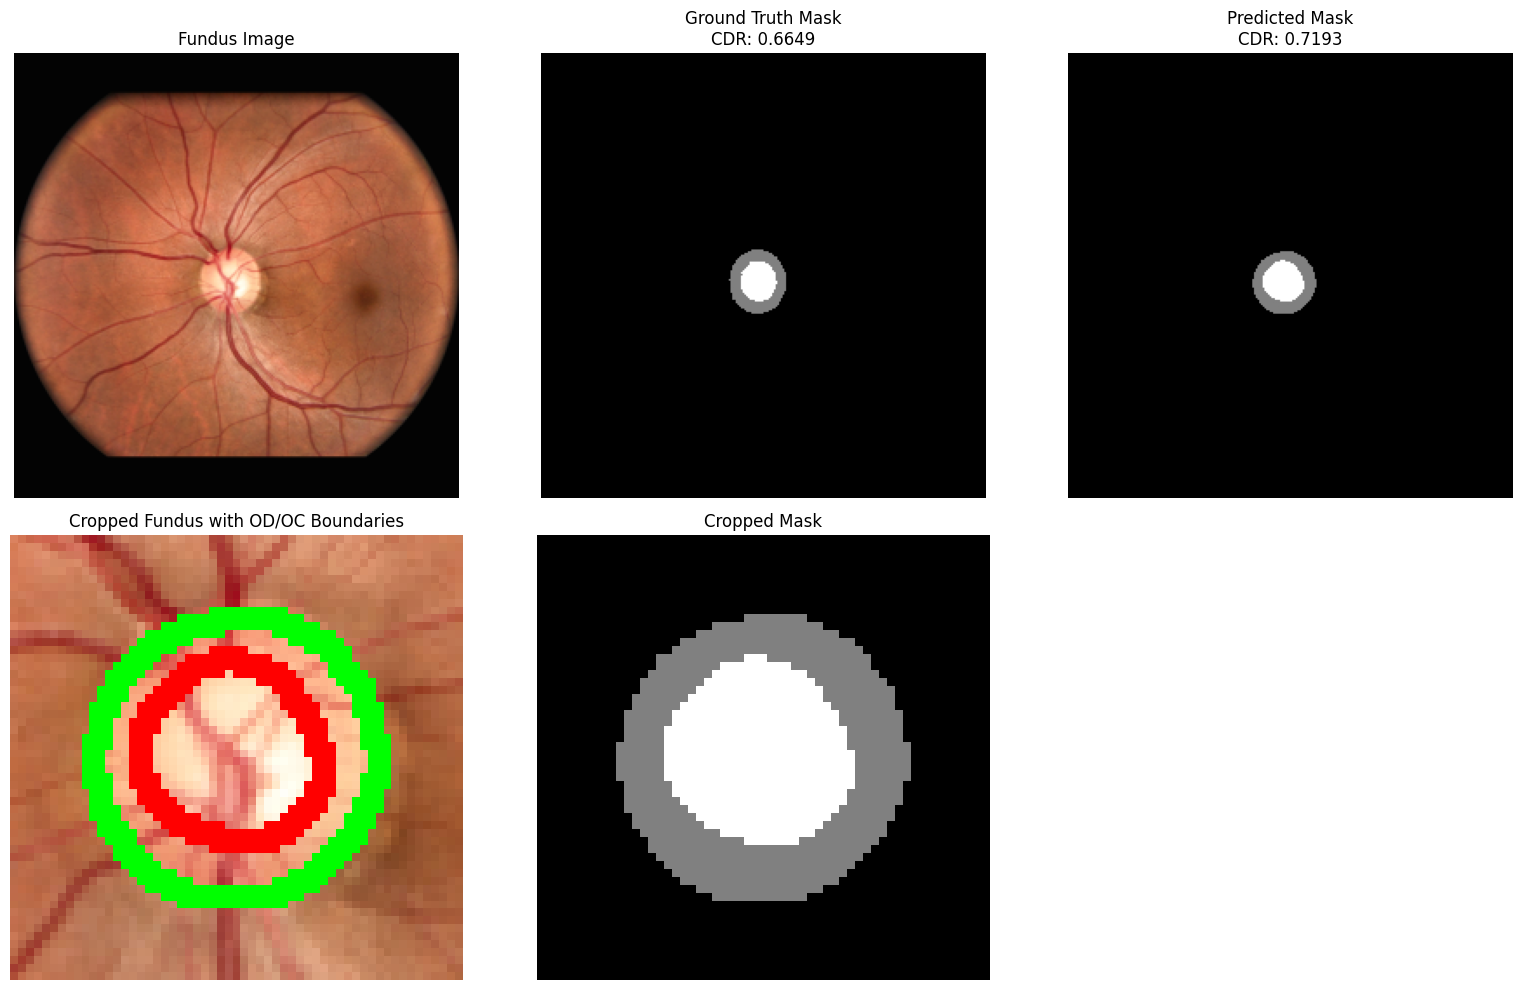

In [ ]:
display_images_and_masks_with_cdr_and_roi("ORIGA-51")